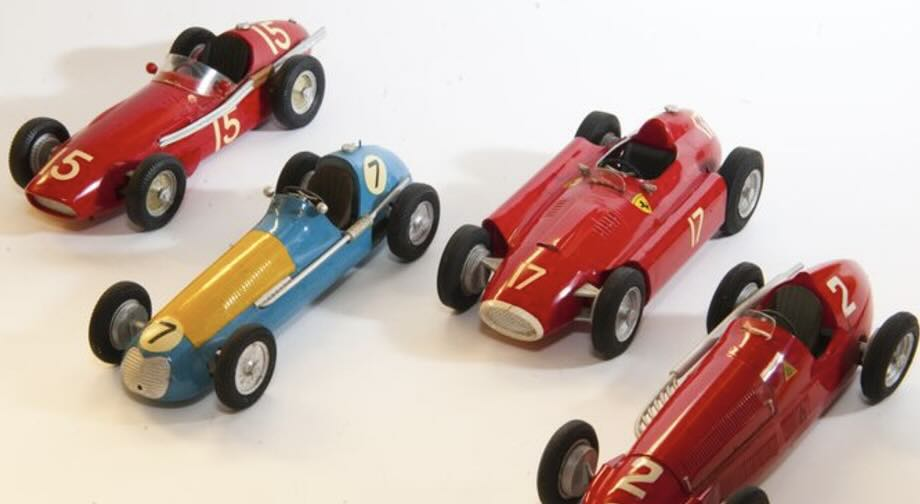

---
### SUMMARY

1. [Read the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [RFM Analysis](#3)
4. [KMeans Clustering](#4)
5. [Final Insights](#5)

---

# 1. Read the Data
<a id="1"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 100)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.stats import kurtosis, skew
from scipy.cluster.hierarchy import linkage, dendrogram

from yellowbrick.cluster import KElbowVisualizer

from warnings import simplefilter
simplefilter("ignore")

from collections import Counter

In [2]:
data = pd.read_csv('/kaggle/input/sample-sales-data/sales_data_sample.csv', encoding='unicode_escape')

data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 2823 rows and 25 columns.


**Null and duplicate values**

In [4]:
data.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

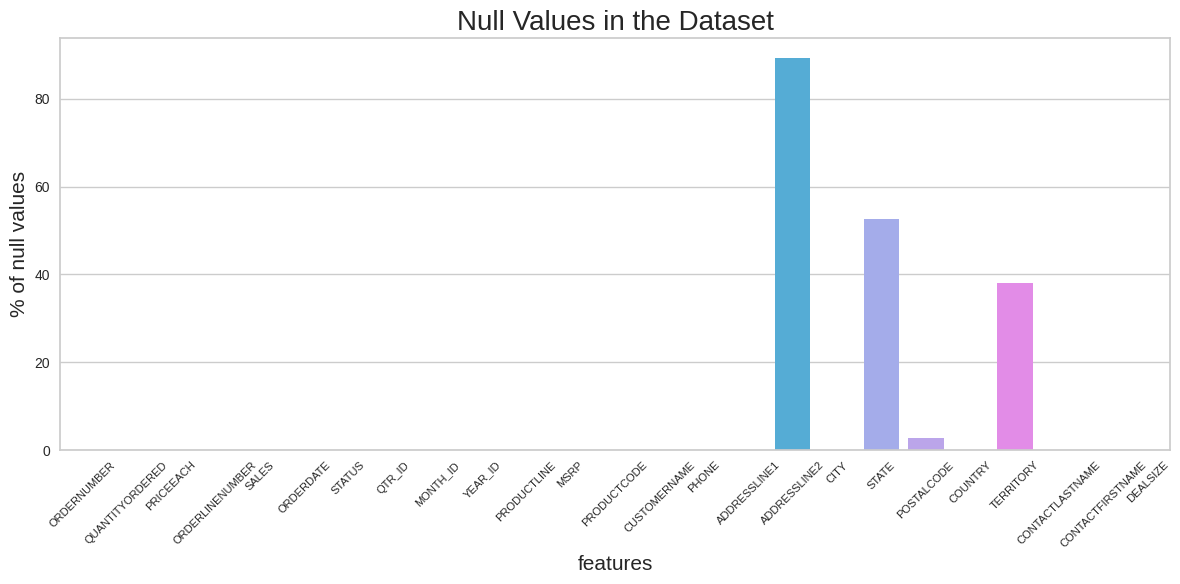

In [5]:
def plot_nulls(data, title, x_axis_label, y_axis_label):
    
    # number of nulls for each column
    data_nulls = (data.apply(lambda x: x.isnull().value_counts()).T[True] / len(data)*100).reset_index(name='count')

    plt.figure(figsize=(12,6))
    sns.barplot(data_nulls, x="index", y="count")
    
    plt.title(title, fontsize=20)
    plt.xlabel(x_axis_label, fontsize=15)
    plt.xticks(rotation=45, fontsize=8)
    plt.ylabel(y_axis_label, fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
plot_nulls(data, "Null Values in the Dataset", 'features', '% of null values')  

There are columns with a high content of nulls, like 'ADDRESSLINE1' and 'STATE'. Some of them might have to be dropped.

In [6]:
print(f'There are {data.duplicated().sum()} suplicate values in the dataset.')

There are 0 suplicate values in the dataset.


**Basic statistics and data types**

In [7]:
data.describe()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2.717676,7.092455,2003.81509,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,1.203878,3.656633,0.69967,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,4.000000,12.000000,2005.00000,214.000000


By having a look at the MIN and MAX values of the features, I do not see particularly off values, like negative or very large ones.

In [8]:
data.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

The data types seem OK. In case I had to use it, I should only have to convert the type of 'ORDERDATE'.

# 2. Exploratory Data Analysis
<a id="2"></a>

## 2.1 Customers and Their Countries

Let's have a look at the customers.

In [9]:
data['CUSTOMERNAME'].head()

0           Land of Toys Inc.
1          Reims Collectables
2             Lyon Souveniers
3           Toys4GrownUps.com
4    Corporate Gift Ideas Co.
Name: CUSTOMERNAME, dtype: object

It seems that the customers are shops rather than consumers. In light of this, I expect the quantity of sales to be pretty high.

Then, let's see what is the total number of different customers.

In [10]:
print(f"There are {data['CUSTOMERNAME'].nunique()} different customers.")

print(f"They are from {data['COUNTRY'].nunique()} different countries and {data['CITY'].nunique()} different cities.")

There are 92 different customers.
They are from 19 different countries and 73 different cities.


Let's plot a map of their count by country.

**Number of customers by country**

In [11]:
data_customers = data.groupby(['COUNTRY'])['CUSTOMERNAME'].nunique().reset_index(name='CUSTOMER_COUNT').sort_values('CUSTOMER_COUNT', ascending=False)

data_customers.head()

,COUNTRY,CUSTOMER_COUNT
18,USA,35
6,France,12
17,UK,5
14,Spain,5
0,Australia,5


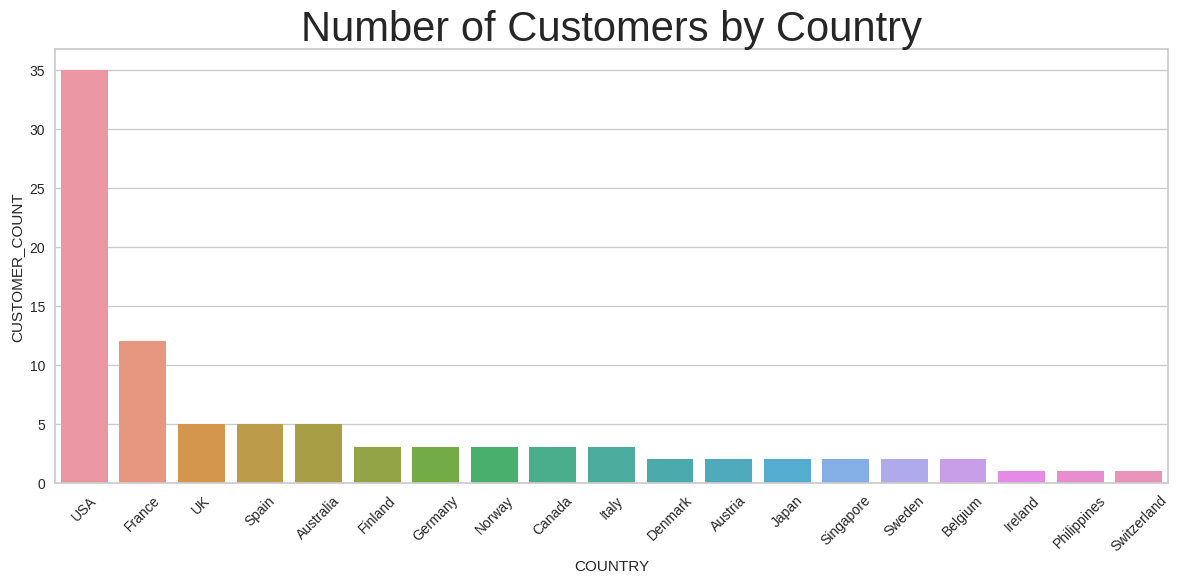

In [12]:
plt.figure(figsize=(12,6))

sns.barplot(data=data_customers, x='COUNTRY', y='CUSTOMER_COUNT')
plt.xticks(rotation=45)
plt.title('Number of Customers by Country', size=30)

plt.tight_layout()

**What are the best customers?**

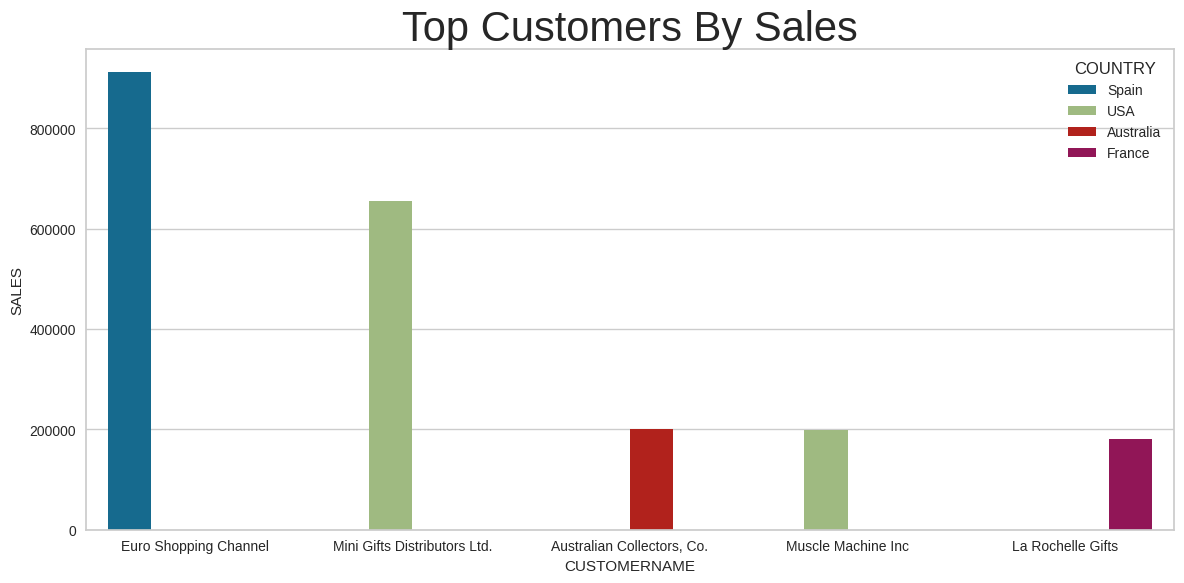

In [13]:
sales_customer = data.groupby(['CUSTOMERNAME', 'COUNTRY'])['SALES'].sum().reset_index().sort_values('SALES', ascending=False).head(5)

plt.figure(figsize=(12,6))

sns.barplot(data=sales_customer, x='CUSTOMERNAME', y='SALES', hue='COUNTRY')
plt.title('Top Customers By Sales', size=30)

plt.tight_layout()

**What are the top buying countries?**

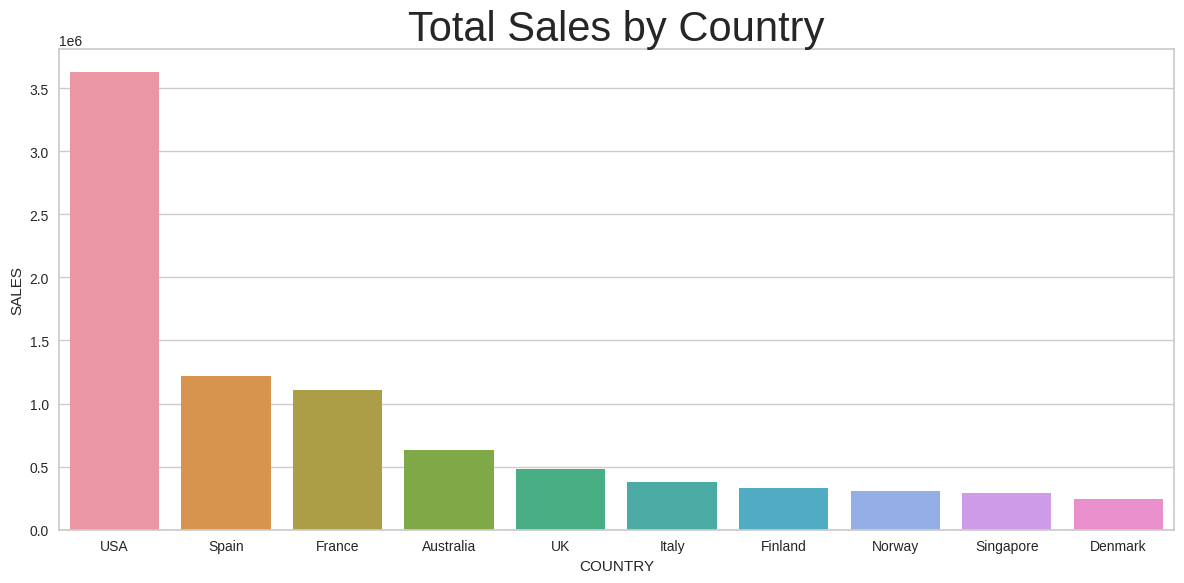

In [14]:
data_sales_country = data.groupby('COUNTRY')['SALES'].sum().reset_index().sort_values('SALES', ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(data=data_sales_country.head(10), x='COUNTRY', y='SALES')
plt.title('Total Sales by Country', size=30)

plt.tight_layout()

The top buying country is the USA. It is also the country with the highest number of customers. 

I want to have a look at the average sales by country, i.e. the sales by country averaged over its total number of companies.

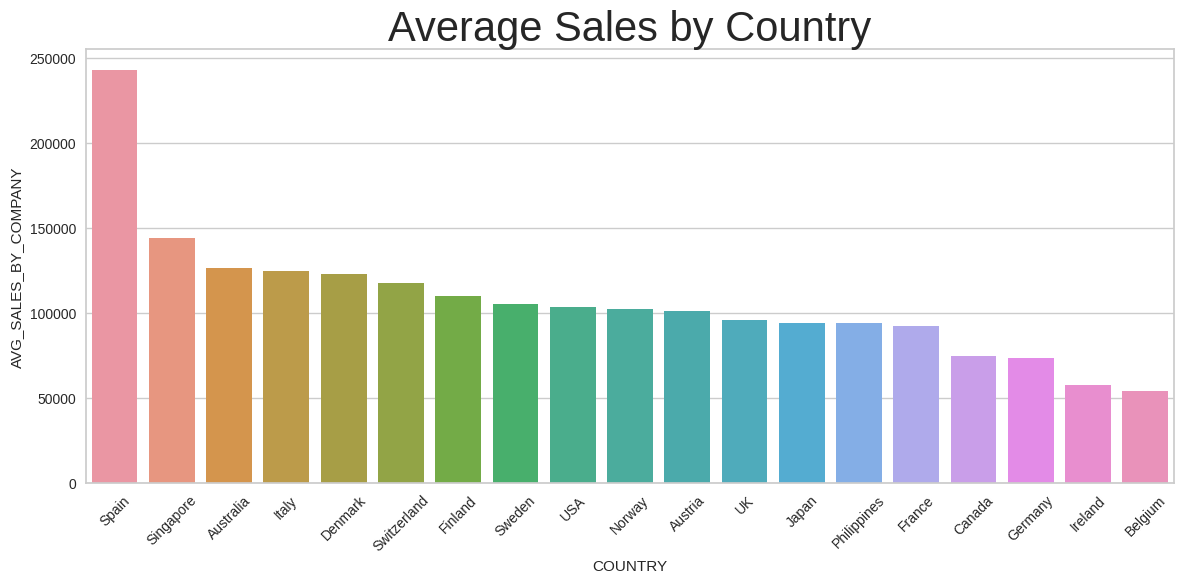

In [15]:
avg_sales_by_company_country = pd.merge(data_customers, data_sales_country, on=['COUNTRY'])

avg_sales_by_company_country['AVG_SALES_BY_COMPANY'] = avg_sales_by_company_country['SALES'] / avg_sales_by_company_country['CUSTOMER_COUNT']

plt.figure(figsize=(12,6))

sns.barplot(data=avg_sales_by_company_country.sort_values('AVG_SALES_BY_COMPANY', ascending=False), x='COUNTRY', y='AVG_SALES_BY_COMPANY')
plt.xticks(rotation=45)
plt.title('Average Sales by Country', size=30)

plt.tight_layout()

This plot basically measures the mean size of the companies from each country. While the USA is the top buying country, the size of its companies is average.

## 2.2 Sales by Year and Month

In [16]:
print(data['YEAR_ID'].unique())

[2003 2004 2005]


The data spans the 2003-2005 years.

In [17]:
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'])

print(f"MIN date: {data['ORDERDATE'].min()}; MAX date: {data['ORDERDATE'].max()}")

MIN date: 2003-01-06 00:00:00; MAX date: 2005-05-31 00:00:00


The data for the year 2005 is incomplete. It runs from January 2003 to May 2005. Given that the second half of the year has Christmas, a fair comparison between 2003, 2004 and 2005 requires restricting the data to the first five months.

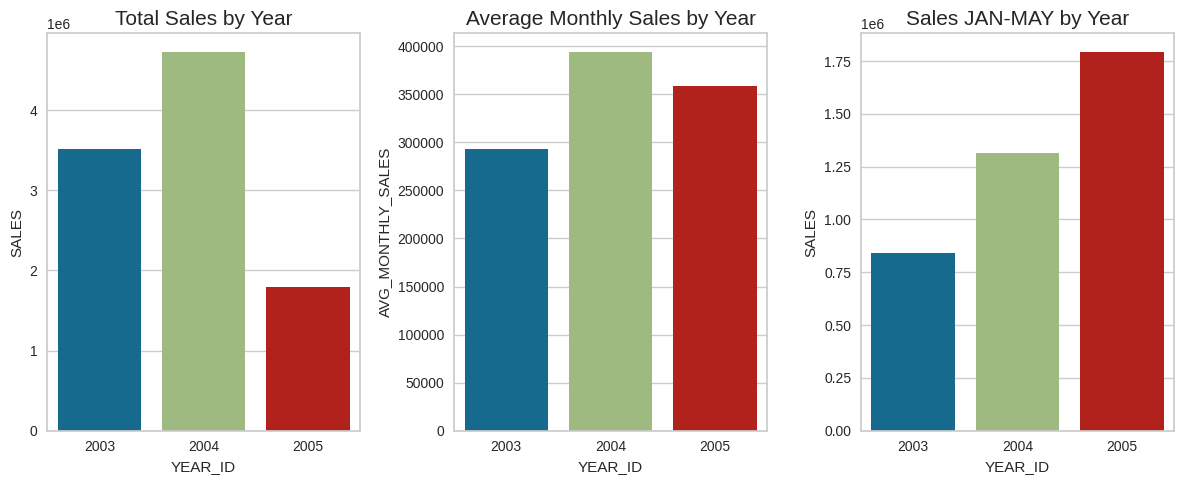

In [18]:
#################################
sales_year = data.groupby('YEAR_ID')['SALES'].sum().reset_index()
sales_year['total no. of months'] = [12, 12, 5]

sales_year['AVG_MONTHLY_SALES'] = sales_year['SALES'] / sales_year['total no. of months']


sales_five_months = data.loc[data['MONTH_ID'].isin([1, 2, 3, 4, 5])].groupby('YEAR_ID')['SALES'].sum().reset_index()
#################################


fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,5))

ax1 = sns.barplot(data=sales_year,x='YEAR_ID',y='SALES',ax=ax1)
ax1.set_title('Total Sales by Year',size=15)

ax2 = sns.barplot(data=sales_year,x='YEAR_ID',y='AVG_MONTHLY_SALES',ax=ax2)
ax2.set_title('Average Monthly Sales by Year',size=15)

ax3 = sns.barplot(data=sales_five_months,x='YEAR_ID',y='SALES',ax=ax3)
ax3.set_title('Sales JAN-MAY by Year',size=15)

plt.tight_layout()

Even though the sales for the second half of the year are missing, 2005 might turn out to be the most fruitful year for the company. 

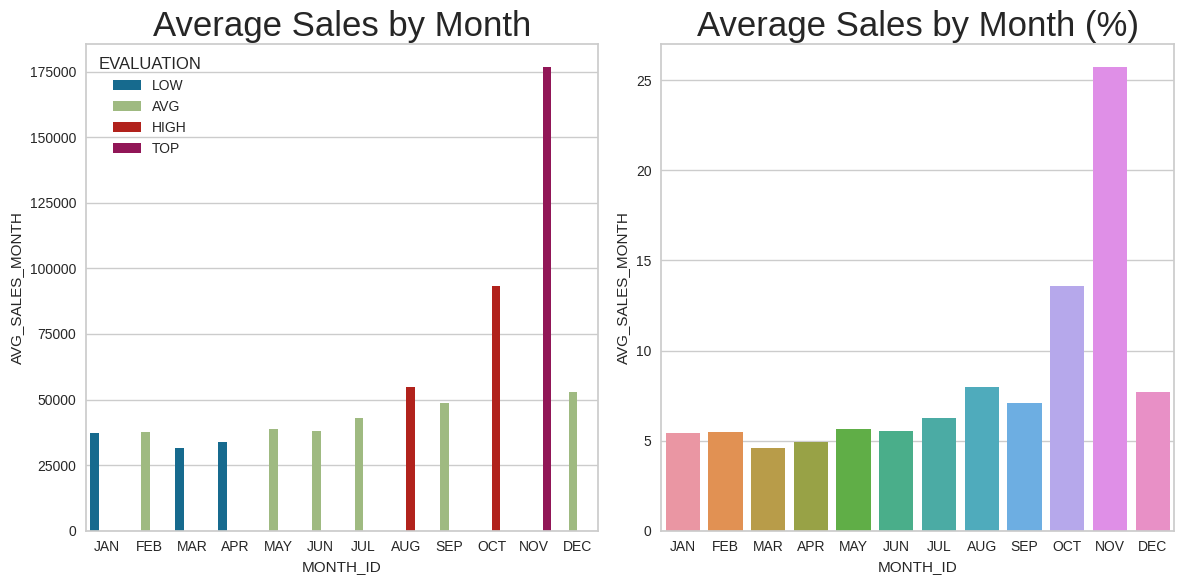

In [19]:
######################################################
sales_month = data.loc[data.YEAR_ID.isin([2003,2004])].groupby('MONTH_ID')['SALES'].sum().reset_index(name='AVG_SALES_MONTH') 
sales_month['AVG_SALES_MONTH'] = sales_month['AVG_SALES_MONTH'] / 12

EVAL = ['LOW', 'AVG', 'LOW', 'LOW', 'AVG', 'AVG', 'AVG', 'HIGH', 'AVG', 'HIGH', 'TOP', 'AVG']

sales_month['EVALUATION'] = EVAL

sales_03_04 = data.loc[data.YEAR_ID.isin([2003,2004])]['SALES'].sum()


sales_month_perc = sales_month.copy() 
sales_month_perc['AVG_SALES_MONTH'] = sales_month_perc['AVG_SALES_MONTH'] / sales_03_04 * 12 * 100
######################################################

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=sales_month, x='MONTH_ID', y='AVG_SALES_MONTH', hue='EVALUATION', ax=ax1)
ax1.set_xticklabels(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])
ax1.set_title('Average Sales by Month', size=25)

ax2 = sns.barplot(data=sales_month_perc, x='MONTH_ID', y='AVG_SALES_MONTH', ax=ax2)
ax2.set_xticklabels(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])
ax2.set_title('Average Sales by Month (%)', size=25)

plt.tight_layout()

As anticipated, the last part of the year has the most sales and the first part has the least. Let's have a look at the sales by season (or quarter).

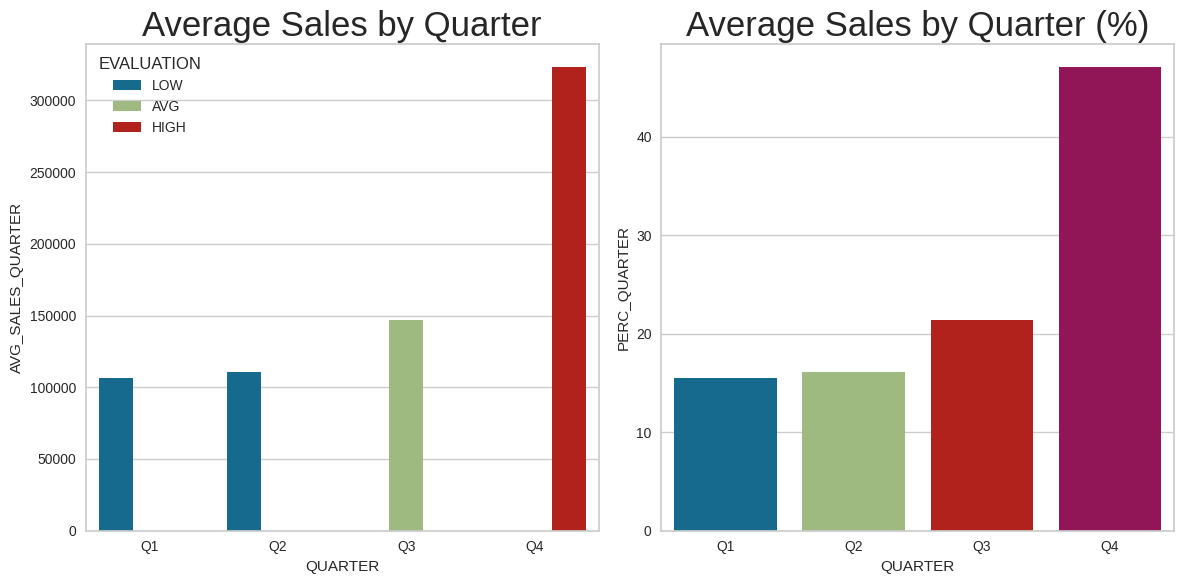

In [20]:
##### Create the column 'season' #####
### Instead of standard seasons, I will rather use the notation Q1 ... Q4. ###
### For example, Q1 = January + February + March; Q2 = April + May + June; and so on. ###
Q1 = [1, 2, 3]
Q2 = [4, 5, 6]
Q3 = [7, 8 , 9]
Q4 = [10, 11, 12]

def month_handler(row):
    if row['MONTH_ID'] in Q1:
        return 'Q1'
    if row['MONTH_ID'] in Q2:
        return 'Q2'
    if row['MONTH_ID'] in Q3:
        return 'Q3'
    if row['MONTH_ID'] in Q4:
        return 'Q4'

sales_month['QUARTER'] = sales_month.apply(month_handler,axis=1) 

sales_season = sales_month.groupby('QUARTER')['AVG_SALES_MONTH'].sum().reset_index(name='AVG_SALES_QUARTER')

TOT_SALES = sales_season['AVG_SALES_QUARTER'].sum()

sales_season['PERC_QUARTER'] = sales_season['AVG_SALES_QUARTER'] / TOT_SALES * 100

EVAL_Q = ['LOW', 'LOW', 'AVG', 'HIGH']

sales_season['EVALUATION'] = EVAL_Q
######################################################

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=sales_season, x='QUARTER', y='AVG_SALES_QUARTER', hue='EVALUATION', ax=ax1)
ax1.set_title('Average Sales by Quarter', size=25)

ax2 = sns.barplot(data=sales_season, x='QUARTER', y='PERC_QUARTER', ax=ax2)
ax2.set_title('Average Sales by Quarter (%)', size=25)

plt.tight_layout()

One can notice that almost half of the sales are made in the last quarter, that is the most important for this business.

Below I am plotting the average sales and their trends.

<Figure size 1800x600 with 0 Axes>

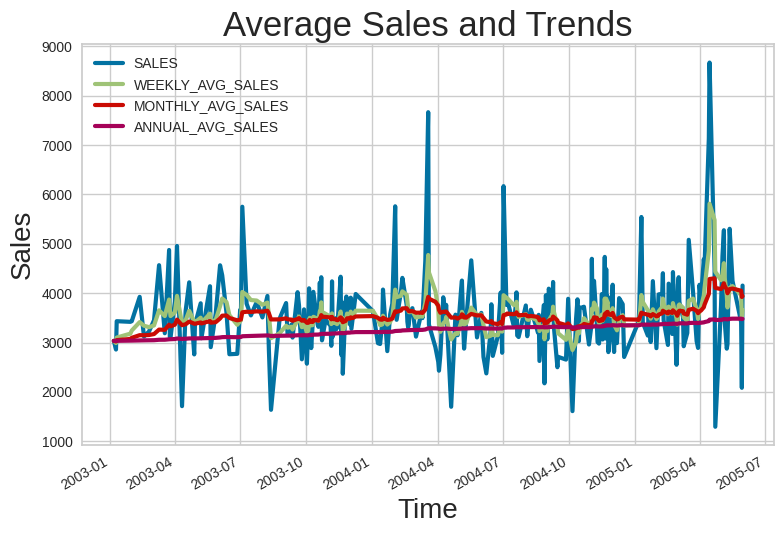

In [21]:
average_sales = data.groupby('ORDERDATE')['SALES'].mean().reset_index()

avg_sales = average_sales.copy()

avg_sales['WEEKLY_AVG_SALES'] = avg_sales['SALES'].ewm(span=7, adjust=False).mean()
avg_sales['MONTHLY_AVG_SALES'] = avg_sales['SALES'].ewm(span=30,adjust=False).mean()
avg_sales['ANNUAL_AVG_SALES'] = avg_sales['SALES'].ewm(span=365,adjust=False).mean()

plt.figure(figsize=(18,6))

avg_sales.plot(x='ORDERDATE', y=['SALES', 'WEEKLY_AVG_SALES', 'MONTHLY_AVG_SALES', 'ANNUAL_AVG_SALES'], linewidth=3) 
plt.title('Average Sales and Trends', size=25)

plt.legend(fontsize=10)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Sales',fontsize=20)

plt.tight_layout();

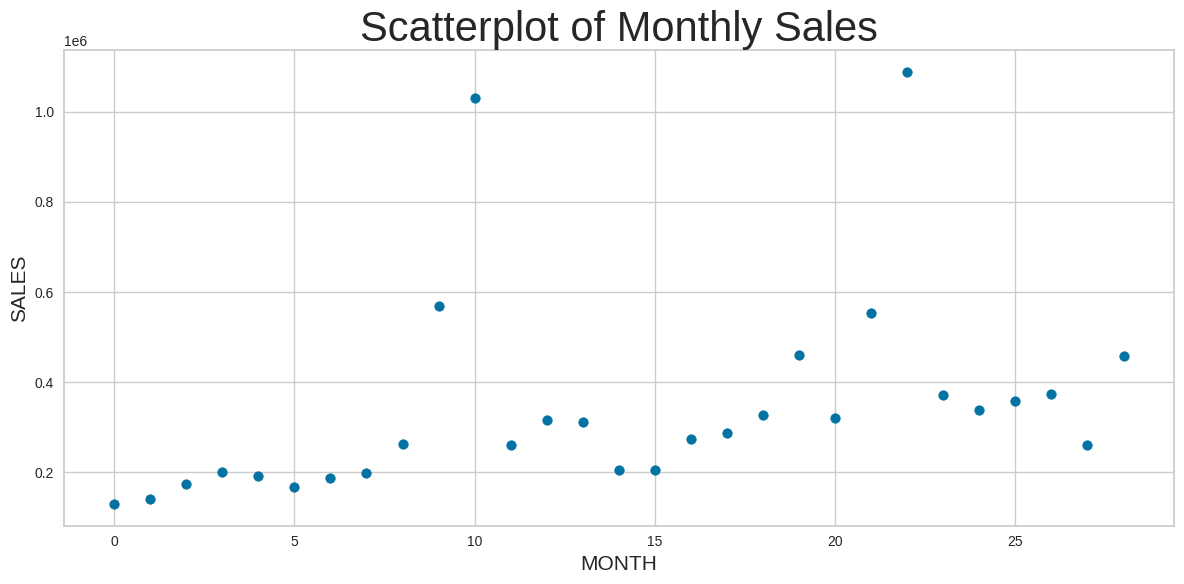

In [22]:
sales_month = data.groupby(['YEAR_ID', 'MONTH_ID'])['SALES'].sum().reset_index()

sales_month.head()


plt.figure(figsize=(12,6))

x = sales_month.index.values
y = sales_month['SALES'].values

plt.scatter(x, y)
plt.title('Scatterplot of Monthly Sales', size=30)
plt.xlabel('MONTH', size=15)
plt.ylabel('SALES', size=15)

plt.tight_layout()

## 2.3 Products

Let's find out what are the products sold by the company, their sales and the average price per item.

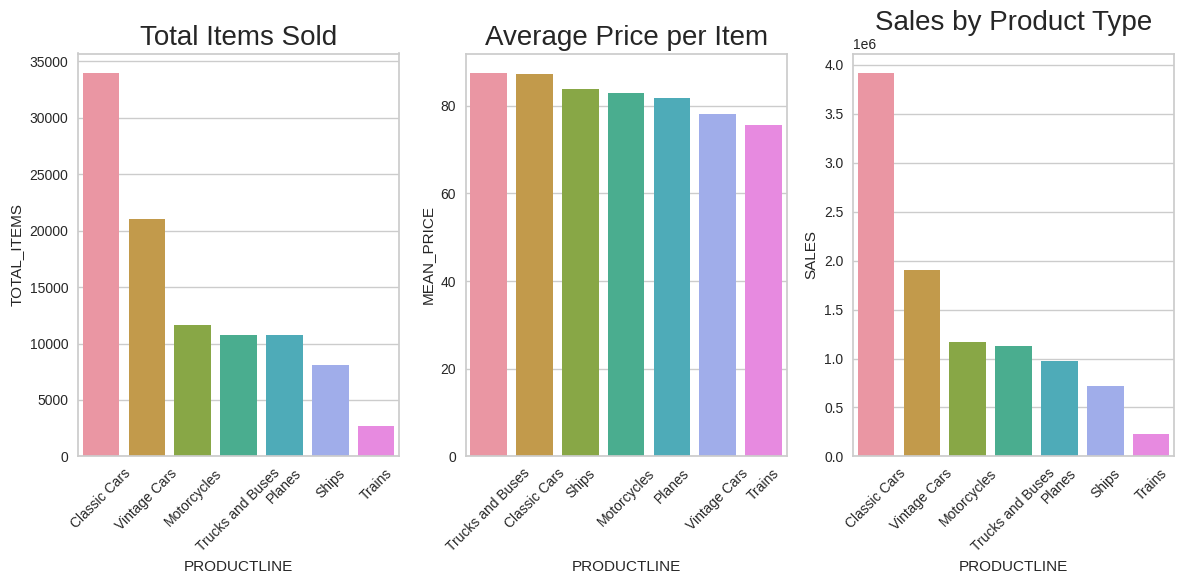

In [23]:
#####################################
product_sales = data.groupby('PRODUCTLINE')['SALES'].sum().reset_index().sort_values('SALES', ascending=False)

product_orders = data.groupby('PRODUCTLINE')['PRODUCTLINE'].value_counts().reset_index(name='COUNT').sort_values('COUNT', ascending=False)

items_sold = data.groupby('PRODUCTLINE')['QUANTITYORDERED'].sum().reset_index(name='TOTAL_ITEMS').sort_values('TOTAL_ITEMS', ascending=False)

product_prices = data.groupby('PRODUCTLINE')['PRICEEACH'].mean().reset_index(name='MEAN_PRICE').sort_values('MEAN_PRICE', ascending=False)
#####################################

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

ax1 = sns.barplot(data=items_sold, x='PRODUCTLINE', y='TOTAL_ITEMS', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Total Items Sold',size=20)

ax2 = sns.barplot(data=product_prices, x='PRODUCTLINE', y='MEAN_PRICE', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Average Price per Item', size=20)

ax3 = sns.barplot(data=product_sales, x='PRODUCTLINE', y='SALES', ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.set_title('Sales by Product Type', size=20)

plt.tight_layout()

It seems that the company sells toy models of motorbikes, cars, planes, and so on. Classic car models are the most successful products and train models the least successful ones. 

Let's plot the sales of the some products.

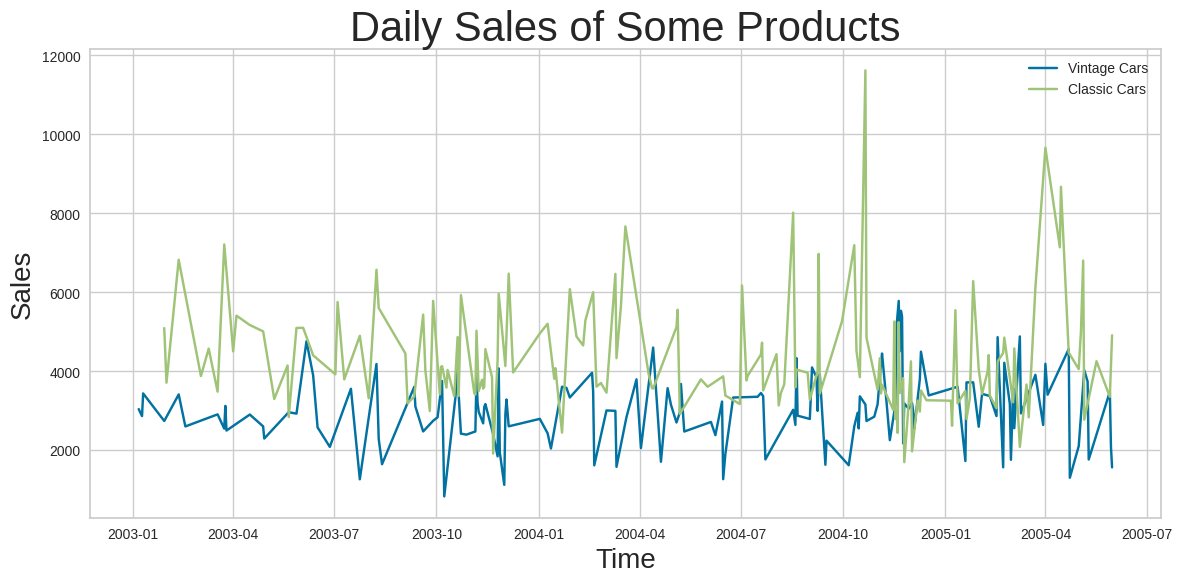

In [24]:
avg_sales_toys = data.loc[data.PRODUCTLINE.isin(['Classic Cars', 'Vintage Cars'])].groupby(['ORDERDATE', 'PRODUCTLINE'])['SALES'].mean().reset_index()

plt.figure(figsize=(12,6))

sns.lineplot(data=avg_sales_toys, x='ORDERDATE', y='SALES', hue='PRODUCTLINE')
plt.title('Daily Sales of Some Products', size=30)

plt.legend(fontsize=10)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Sales',fontsize=20)

plt.tight_layout();

## 2.4 Prices

I want to find out whether there was a change in the average prices of the products in the 2003-2005 period.

In [25]:
avg_prices_year = data.groupby(['YEAR_ID'])['PRICEEACH'].mean()

avg_prices_year

YEAR_ID
2003    83.793140
2004    83.634275
2005    83.445251
Name: PRICEEACH, dtype: float64

No, there was not. 

Now, I want to know whether there is a monthly or seasonal variation in prices. The variation in the average price of the items sold can be related to the different combination of the items that are sold, given that they all have different prices.

In [26]:
avg_prices_month = data.groupby(['MONTH_ID'])['PRICEEACH'].mean()

avg_prices_month

MONTH_ID
1     83.457555
2     84.386116
3     82.229292
4     82.939775
5     83.878611
6     83.003893
7     85.856525
8     83.634084
9     83.496374
10    83.953375
11    83.736064
12    83.253222
Name: PRICEEACH, dtype: float64

The average price of the items does not change much in the course of the year. Let's see if the prices of some specific products (or product categories) change.

In [27]:
avg_prices_year_product = data.groupby(['YEAR_ID', 'PRODUCTLINE'])['PRICEEACH'].mean()

avg_prices_year_product

YEAR_ID  PRODUCTLINE     
2003     Classic Cars        88.179918
         Motorcycles         82.923578
         Planes              81.115529
         Ships               82.963457
         Trains              71.036429
         Trucks and Buses    88.919909
         Vintage Cars        77.355430
2004     Classic Cars        86.940995
         Motorcycles         82.094878
         Planes              82.958944
         Ships               83.097391
         Trains              79.292703
         Trucks and Buses    87.444155
         Vintage Cars        78.637782
2005     Classic Cars        86.490126
         Motorcycles         85.688966
         Planes              79.358500
         Ships               88.051053
         Trains              75.213333
         Trucks and Buses    84.645918
         Vintage Cars        78.502745
Name: PRICEEACH, dtype: float64

This table shows that the average prices of the product categories went up and down in the 2003-2005 period. To get further insights we should have more details about classic car, plane, ship ... models. There could be many of them and not only one per category.

## 2.5 Shipping Status

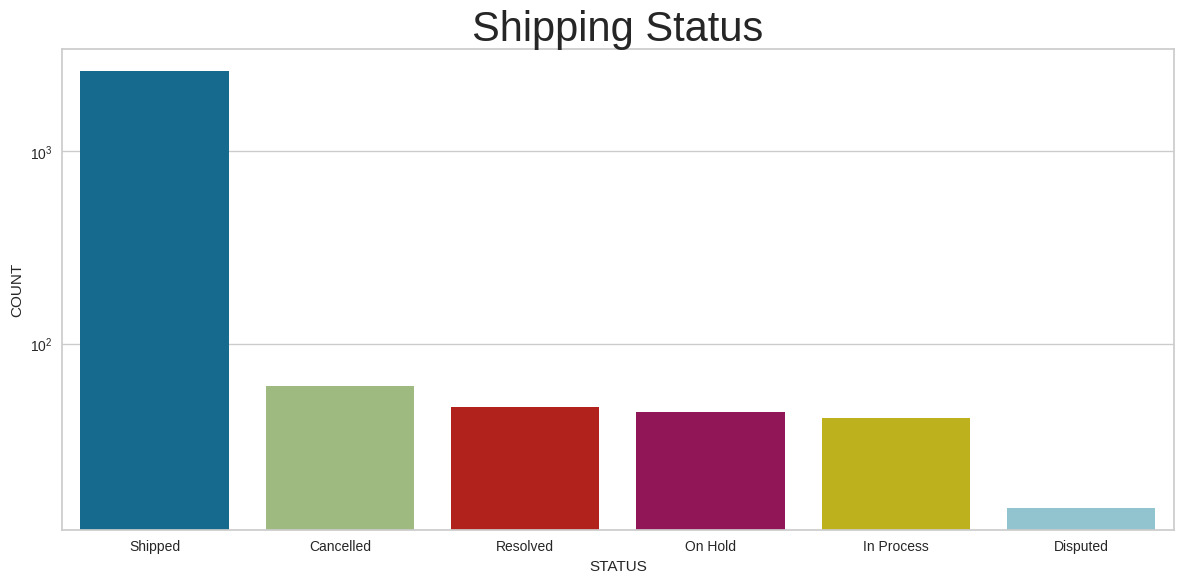

In [28]:
shipping_status = data['STATUS'].value_counts().reset_index(name='COUNT').sort_values('COUNT', ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(data=shipping_status, x='STATUS', y='COUNT')
plt.title('Shipping Status', size=30)
plt.yscale('log')

plt.tight_layout()

The plot shows that the large majority of the orders have been shipped. However, there is a minor (but non-negligible) fraction of the orders that was cancelled, it is on hold or disputed. It would be important to reduce the number of these unfavorable events in order to increase the profits.

In [29]:
cancelled_count = (data.loc[data.STATUS == 'Cancelled']
    .groupby('COUNTRY')['ORDERNUMBER'].count()
    .reset_index(name='CANCELLED_COUNT')
    .sort_values('CANCELLED_COUNT', ascending=False))

cancelled_count

,COUNTRY,CANCELLED_COUNT
0,Spain,16
1,Sweden,16
2,UK,14
3,USA,14


These are the total cancelled orders, grouped by country. Let's have a look at the total number of orders that came from those four countries and also at the percentage of orders that were cancelled by country.

In [30]:
total_count = (data.loc[data.COUNTRY.isin(['Spain', 'Sweden', 'UK', 'USA'])]
        .groupby('COUNTRY')['ORDERNUMBER'].count()
        .reset_index(name='TOTAL_COUNT')
        .sort_values('TOTAL_COUNT', ascending=False))

cancelled_count = cancelled_count.merge(total_count)

cancelled_count['CANCELLED_FRACTION'] = (cancelled_count['CANCELLED_COUNT'] / cancelled_count['TOTAL_COUNT'] * 100).round(1)

cancelled_count = cancelled_count.sort_values('CANCELLED_FRACTION', ascending=False)

cancelled_count

,COUNTRY,CANCELLED_COUNT,TOTAL_COUNT,CANCELLED_FRACTION
1,Sweden,16,57,28.1
2,UK,14,144,9.7
0,Spain,16,342,4.7
3,USA,14,1004,1.4


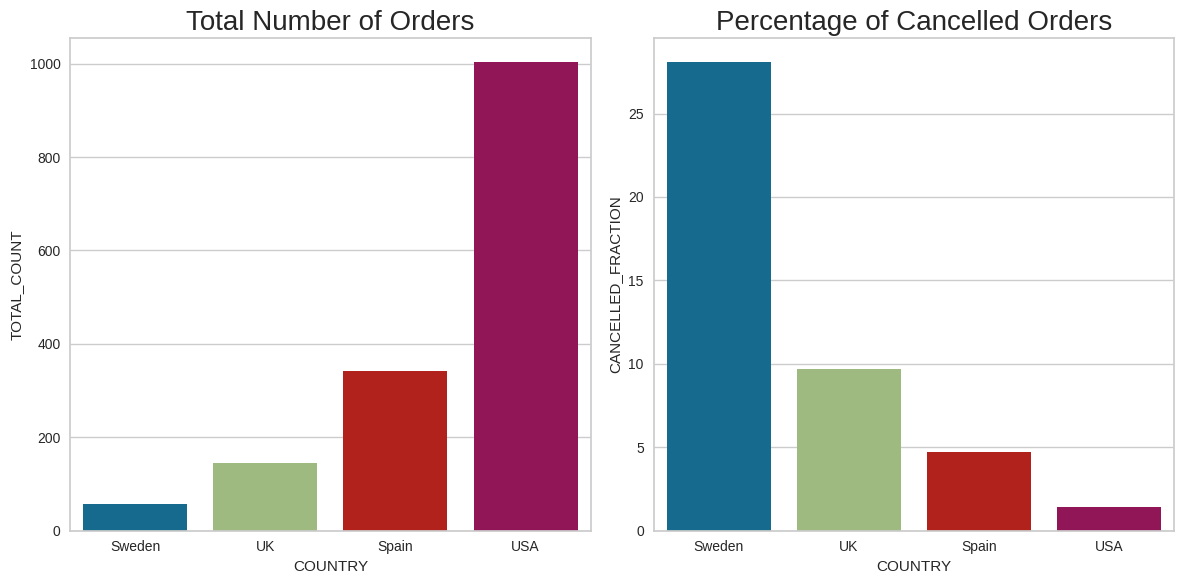

In [31]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=cancelled_count, x='COUNTRY', y='TOTAL_COUNT',ax=ax1)
ax1.set_title('Total Number of Orders', size=20)

ax2 = sns.barplot(data=cancelled_count, x='COUNTRY', y='CANCELLED_FRACTION',ax=ax2)
ax2.set_title('Percentage of Cancelled Orders', size=20)

plt.tight_layout()

This plot shows that the fraction of cancelled orders in some countries (notably Sweden and UK) is very high and worrying. Something should be done to reduce these fractions.

# 3. RFM Analysis
<a id="3"></a>

RFM (Recency, Frequency, Monetary) Analysis is a customer segmentation technique for analyzing customer value based on their past buying behavior. I am using it to analyze some aspects of the data and later for clustering.

## 3.1 Customer Recency

I am defining, for each customer, the last purchase date and also the customer recency (i.e. the number of days before the last purchase).

In [32]:
data['LAST_PURCHASE_DATE'] = data.groupby('CUSTOMERNAME')['ORDERDATE'].transform(max)
data['LAST_PURCHASE_DATE'] = pd.to_datetime(data['LAST_PURCHASE_DATE']) 

data["CUSTOMER_RECENCY_BEFORE_AVG"] = (data["ORDERDATE"] - data["LAST_PURCHASE_DATE"]).dt.days.abs()

data.drop('LAST_PURCHASE_DATE', axis=1, inplace=True)

data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,CUSTOMER_RECENCY_BEFORE_AVG
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small,630
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small,693
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,625
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium,506
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium,502


In [33]:
recency_df = data.groupby('CUSTOMERNAME')['CUSTOMER_RECENCY_BEFORE_AVG'].mean().reset_index(name='RECENCY')

recency_df.head()

,CUSTOMERNAME,RECENCY
0,"AV Stores, Co.",202.705882
1,Alpha Cognac,398.550000
2,Amica Models & Co.,15.038462
3,"Anna's Decorations, Ltd",314.021739
4,Atelier graphique,334.000000


Let's find out what is the average value of recency.

In [34]:
recency_df['RECENCY'].mean()

217.6799987515513

The mean value of recency is more than 7 months! Apparently, there are customers that do not place their orders so often. Let's plot the recency distribution.

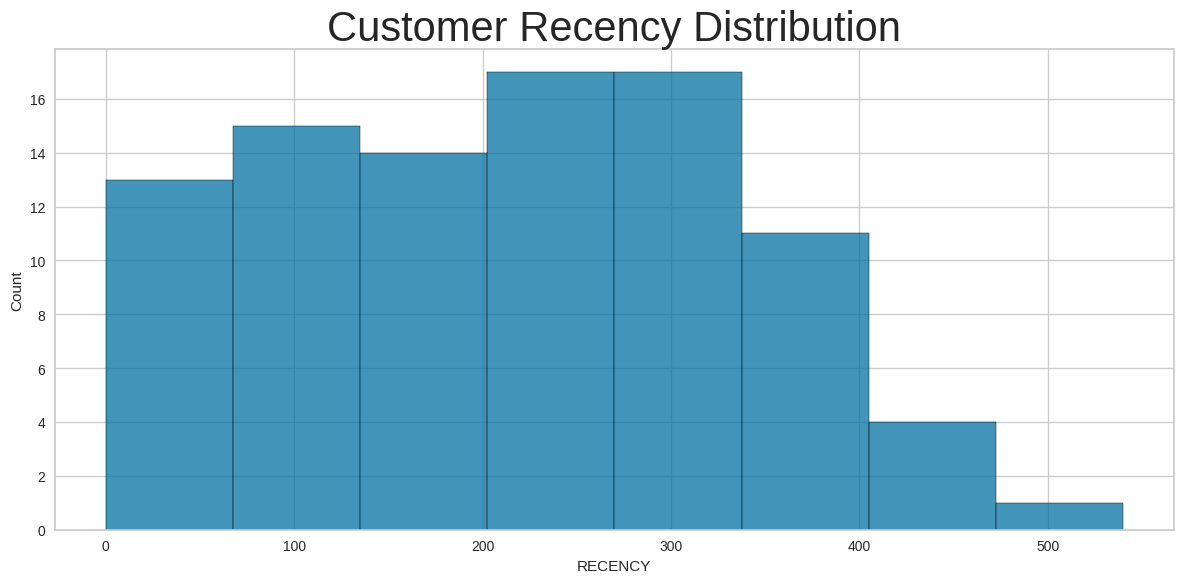

In [35]:
plt.figure(figsize=(12,6))

sns.histplot(data=recency_df, x='RECENCY')
plt.title('Customer Recency Distribution',size=30)

plt.tight_layout()

The histogram of recency is that of a relatively symmetric distribution, but flat. Let's calculate its skewness and kurtosis.

In [36]:
print(f"Skewness of the recency distribution: {skew(recency_df['RECENCY'])}")
print(f"Kurtosis of the recency distribution: {kurtosis(recency_df['RECENCY'])}")

Skewness of the recency distribution: 0.09599882021648815
Kurtosis of the recency distribution: -0.7141636647855321


## 3.2 Customer Frequency

'Frequency' is related to the number of times a customer places an order in a given time interval. So, it is basically the count of his/her invoices.

In [37]:
frequency_df = data.groupby('CUSTOMERNAME')['ORDERNUMBER'].nunique().reset_index(name='FREQUENCY')

frequency_df.head()

,CUSTOMERNAME,FREQUENCY
0,"AV Stores, Co.",3
1,Alpha Cognac,3
2,Amica Models & Co.,2
3,"Anna's Decorations, Ltd",4
4,Atelier graphique,3


Here, I have used the function 'nunique' instead of 'count' because in the dataset there are multiple lines corresponding to the same order.

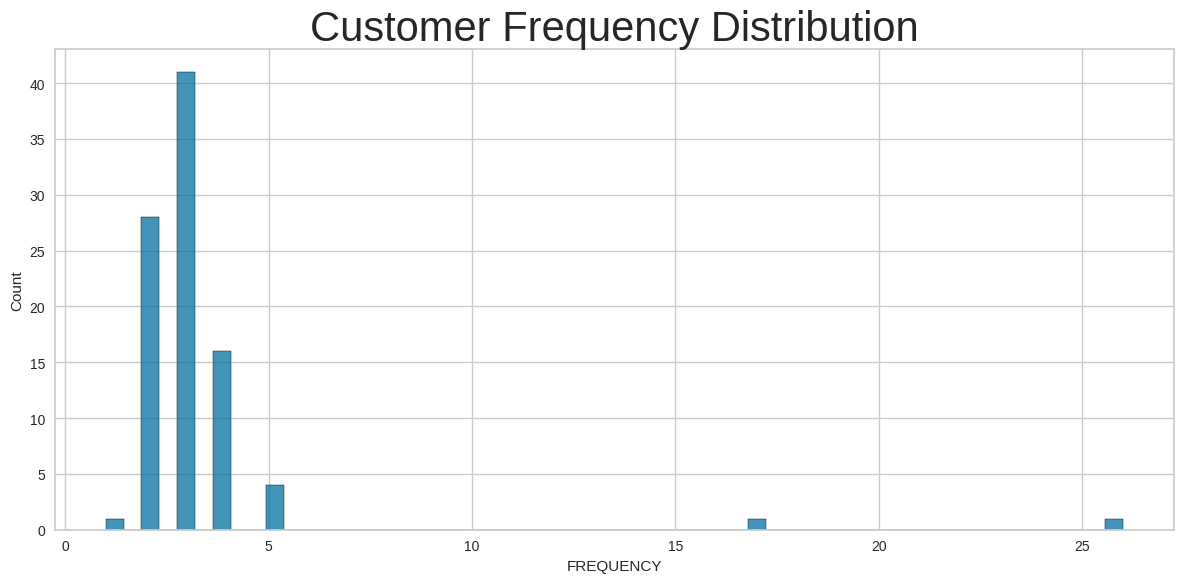

In [38]:
plt.figure(figsize=(12,6))

sns.histplot(data=frequency_df, x='FREQUENCY')
plt.title('Customer Frequency Distribution',size=30)

plt.tight_layout()

Compared to the previous distribution, that of recency which was more flat, the frequency distribution is very narrow and has a long tail. 
Let's have a look at its values of skewness and kurtosis.

In [39]:
print(f"Skewness of the frequency distribution: {skew(frequency_df['FREQUENCY'])}")
print(f"Kurtosis of the frequency distribution: {kurtosis(frequency_df['FREQUENCY'])}")

Skewness of the frequency distribution: 6.239910789921172
Kurtosis of the frequency distribution: 42.351586601786806


## 3.3 Customer Monetary Value

A customer's monetary value is the total amount that he/she has spent on product orders.

In [40]:
monetary_value_df = data.groupby('CUSTOMERNAME')['SALES'].sum().reset_index(name='MONETARY_VALUE')

monetary_value_df.head()

,CUSTOMERNAME,MONETARY_VALUE
0,"AV Stores, Co.",157807.81
1,Alpha Cognac,70488.44
2,Amica Models & Co.,94117.26
3,"Anna's Decorations, Ltd",153996.13
4,Atelier graphique,24179.96


Let's have a look at its distribution.

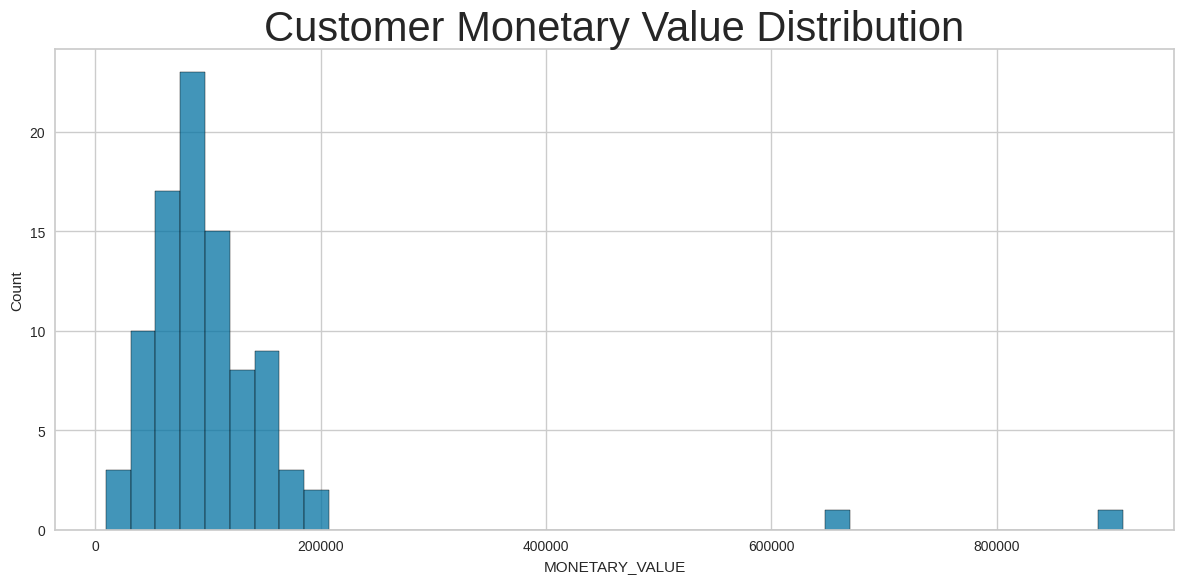

In [41]:
plt.figure(figsize=(12,6))

sns.histplot(data=monetary_value_df, x='MONETARY_VALUE')
plt.title('Customer Monetary Value Distribution',size=30)

plt.tight_layout()

The distribution looks relatively symmetric, but at the same time it is also narrow and it has a very long tail (it is right-skewed). 

In [42]:
print(f"Skewness of the monetary value distribution: {skew(monetary_value_df['MONETARY_VALUE'])}")
print(f"Kurtosis of the monetary value distribution: {kurtosis(monetary_value_df['MONETARY_VALUE'])}")

Skewness of the monetary value distribution: 5.570979953309046
Kurtosis of the monetary value distribution: 34.94842076540168


## 3.4 RFM Dataframe: Merging, Scaling and Outliers

**RFM Dataframe**

The RFM dataframe is created by merging the previous dataframes (those of recency, frequency and monetary value).

In [43]:
RFM_df = pd.merge(recency_df, frequency_df)

RFM_df = pd.merge(RFM_df, monetary_value_df)

RFM_df.head()

,CUSTOMERNAME,RECENCY,FREQUENCY,MONETARY_VALUE
0,"AV Stores, Co.",202.705882,3,157807.81
1,Alpha Cognac,398.550000,3,70488.44
2,Amica Models & Co.,15.038462,2,94117.26
3,"Anna's Decorations, Ltd",314.021739,4,153996.13
4,Atelier graphique,334.000000,3,24179.96


**Outliers**

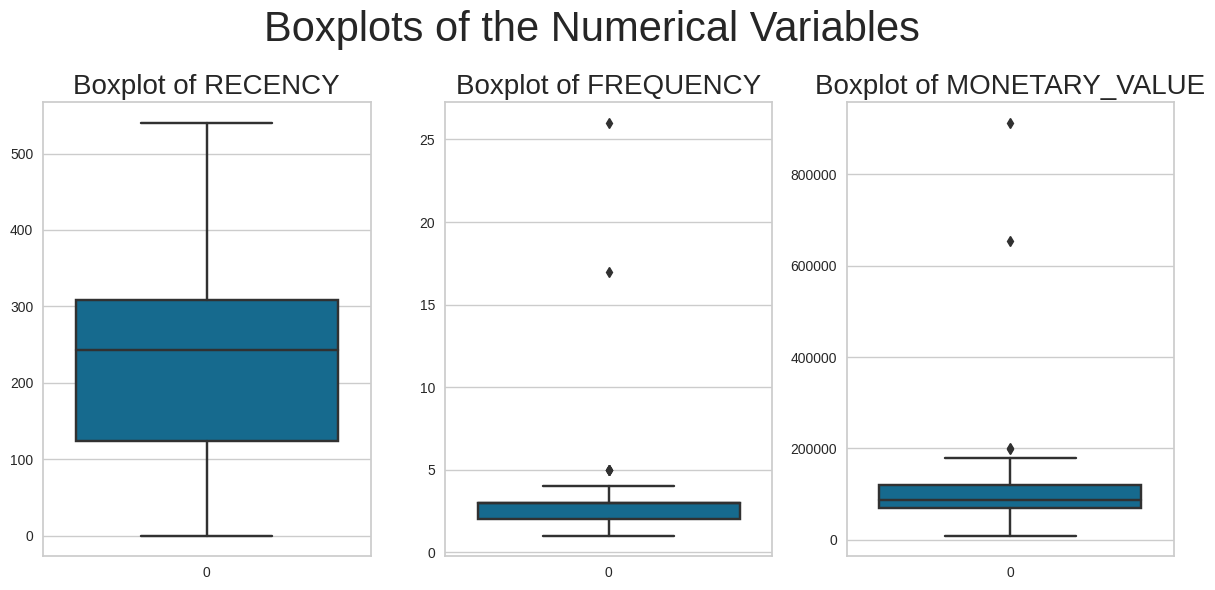

In [44]:
num_features = ['RECENCY', 'FREQUENCY',	'MONETARY_VALUE']


fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.boxplot(RFM_df[num_features[0]],ax=ax1)
ax1.set_title('Boxplot of '+str(num_features[0]),fontsize=20)

ax2 = sns.boxplot(RFM_df[num_features[1]],ax=ax2)
ax2.set_title('Boxplot of '+str(num_features[1]),fontsize=20)

ax3 = sns.boxplot(RFM_df[num_features[2]],ax=ax3)
ax3.set_title('Boxplot of '+str(num_features[2]),fontsize=20)

plt.suptitle('Boxplots of the Numerical Variables',size=30)

plt.tight_layout()

There are outliers both in the 'FREQUENCY' and 'MONETARY_VALUE' columns. Let's find out what is the fraction of them.

In [45]:
outliers_perc = []

for k,v in RFM_df[num_features].items():
    # Column must be of numeric type (not object)
    if RFM_df[k].dtype != 'O':
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(RFM_df)[0]
        out_tuple = (k, int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.1f%%" % (k,perc))

Column RECENCY outliers = 0.0%
Column FREQUENCY outliers = 6.5%
Column MONETARY_VALUE outliers = 4.3%


I will keep a copy of the dataframe with the outliers and create a version of it without them.

In [46]:
RFM_df_filtered = RFM_df.copy()

for k,v in RFM_df_filtered[num_features].items():
    # Column must be of numeric type (not object)
    if RFM_df_filtered[k].dtype != 'O':
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        lower_threshold = q1 - 1.5 * irq
        upper_threshold = q3 + 1.5 * irq
        RFM_df_filtered = RFM_df_filtered[(RFM_df_filtered[k] < upper_threshold) & (RFM_df_filtered[k] > lower_threshold)]

**Scaling**

Then, I am scaling the variables in the two dataframes (both the filtered and the unfiltered one).

In [47]:
# Unfiltered dataframe
RFM_df2 = RFM_df.drop('CUSTOMERNAME', axis=1)

std_scaler = StandardScaler()

RFM_columns = RFM_df2.columns

RFM_df2[RFM_columns] = std_scaler.fit_transform(RFM_df2[RFM_columns])

RFM_df2.describe()

,RECENCY,FREQUENCY,MONETARY_VALUE
count,9.200000e+01,9.200000e+01,9.200000e+01
mean,1.399846e-16,2.896234e-17,-2.003229e-16
std,1.005479e+00,1.005479e+00,1.005479e+00
min,-1.740981e+00,-8.033413e-01,-9.107945e-01
25%,-7.557822e-01,-4.595859e-01,-3.547696e-01
50%,2.055953e-01,-1.158306e-01,-2.053434e-01
75%,7.216740e-01,-1.158306e-01,1.050572e-01
max,2.577508e+00,7.790542e+00,7.321687e+00


In [48]:
RFM_df2_filtered = RFM_df_filtered.drop('CUSTOMERNAME', axis=1)

std_scaler = StandardScaler()

RFM_columns = RFM_df2_filtered.columns

RFM_df2_filtered[RFM_columns] = std_scaler.fit_transform(RFM_df2_filtered[RFM_columns])

RFM_df2_filtered.describe()

,RECENCY,FREQUENCY,MONETARY_VALUE
count,8.500000e+01,8.500000e+01,8.500000e+01
mean,3.134747e-17,-2.716781e-16,3.604959e-16
std,1.005935e+00,1.005935e+00,1.005935e+00
min,-1.723463e+00,-2.524417e+00,-2.240701e+00
25%,-7.709116e-01,-1.140059e+00,-6.118928e-01
50%,-7.527445e-03,2.442984e-01,-1.767197e-01
75%,6.857730e-01,2.442984e-01,6.793296e-01
max,2.150055e+00,1.628656e+00,2.522283e+00


# 4. KMeans Clustering
<a id="4"></a>

## 4.1 'Best' Value of k

### 4.1.1 Elbow Method

**Unfiltered case**

I will start with the unfiltered dataset case. 

I am defining a function to display the values of inertia vs k. 

In [49]:
def elbow(data_in, range_value):

    inertia_values = []

    for k in range_value:
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
        kmeans.fit(data_in)
        inertia_values.append(kmeans.inertia_)

    ### Plotting the inertia values
    features = data_in.columns
    print(features)

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

    # First Plot
    ax1.plot(range_value, inertia_values, marker='o', linestyle='-')
    ax1.xaxis.set_tick_params(labelsize=13)
    ax1.set_xticklabels(ax1.get_xticks().astype(int))
    ax1.yaxis.set_tick_params(labelsize=13)
    ax1.set_xlabel("number of clusters", fontsize=15)
    ax1.set_ylabel('inertia', fontsize=15)
    ax1.set_title("Elbow Method", fontsize=22)

    # Second Plot
    Elbow_M = KElbowVisualizer(KMeans(), k=15)
    Elbow_M.fit(data_in[features])
    ax2 = Elbow_M.show()

    plt.tight_layout()

Index(['RECENCY', 'FREQUENCY', 'MONETARY_VALUE'], dtype='object')


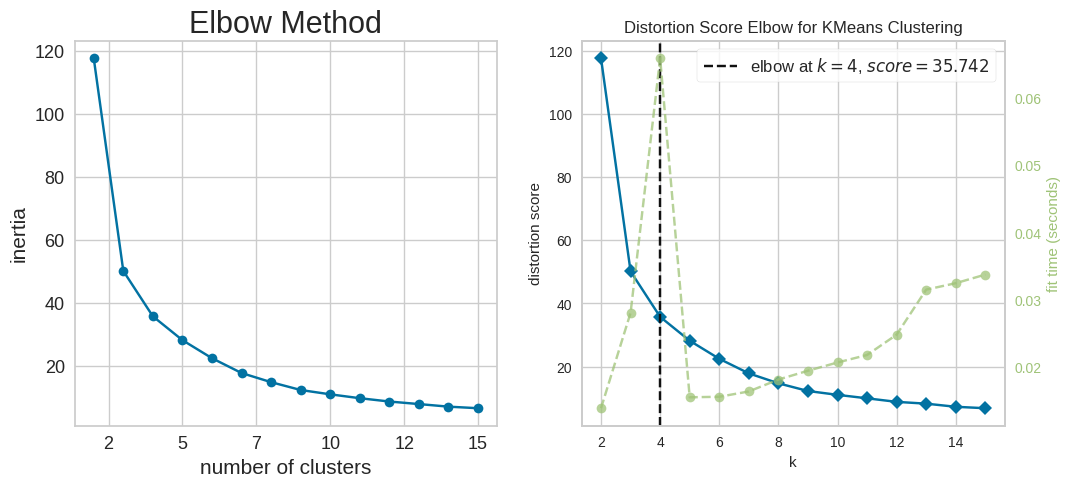

<Figure size 800x550 with 0 Axes>

In [50]:
range_clusters = range(2, 16)

elbow(RFM_df2, range_clusters)

The 'best' number of clusters in the unfiltered case is between 3 and 5.

**Filtered case**

Index(['RECENCY', 'FREQUENCY', 'MONETARY_VALUE'], dtype='object')


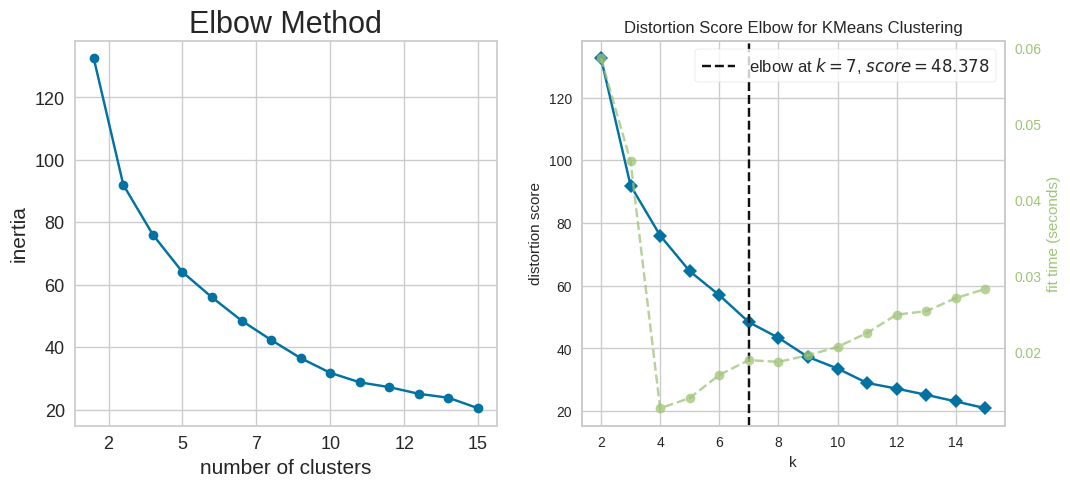

<Figure size 800x550 with 0 Axes>

In [51]:
elbow(RFM_df2_filtered, range_clusters)

The 'best' number of clusters in the filtered case is very different: k = 5 or higher.

### 4.1.2 Davies-Bouldin Score

**Unfiltered case**

In [52]:
def db_score(data_in, range_value):

    davies_bouldin_scores = []

    for k in range_value:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_in)
        score = davies_bouldin_score(data_in, labels)
        davies_bouldin_scores.append(score)

    plt.plot(range_clusters, davies_bouldin_scores, marker='o')
    plt.xlabel("number of clusters", fontsize=15)
    plt.ylabel('Davies-Bouldin index', fontsize=15)
    plt.title("Davies-Bouldin Index", fontsize=22)

    plt.tight_layout()
    plt.show()    

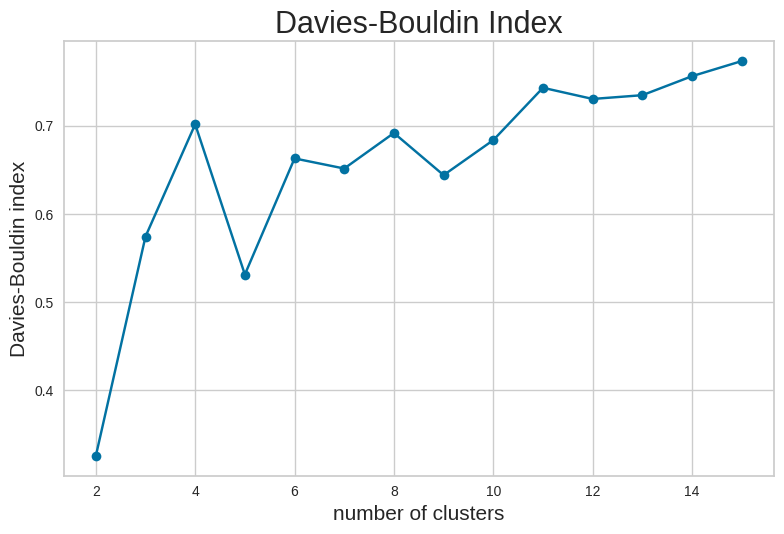

In [53]:
db_score(RFM_df2, range_clusters)

In the unfiltered case, according to the Davies-Bouldin score the 'best' number of clusters would be 2.

**Filtered case**

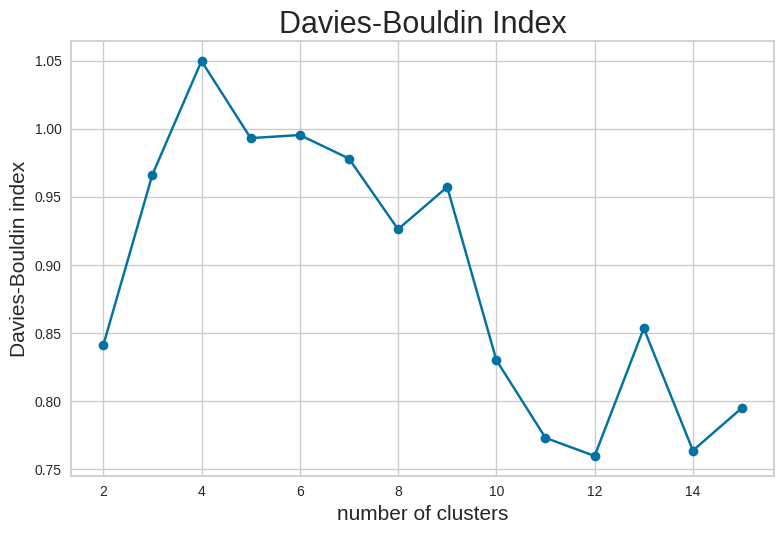

In [54]:
db_score(RFM_df2_filtered, range_clusters)

In the filtered case, the number of clusters would be either k = 2 or higher (k in the 10 - 14 range).

### 4.1.3 Silhouette Score

**Unfiltered case**

In [55]:
def silhouette(data_in, range_value):

    silhouette_scores = []

    for k in range_value:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_in) 
        score = silhouette_score(data_in, labels)
        silhouette_scores.append(score)

    plt.plot(range_value, silhouette_scores, marker='o')
    plt.xlabel("number of clusters", fontsize=15)
    plt.ylabel('silhouette score', fontsize=15)
    plt.title("Silhouette Score", fontsize=22)

    plt.tight_layout()
    plt.show()   

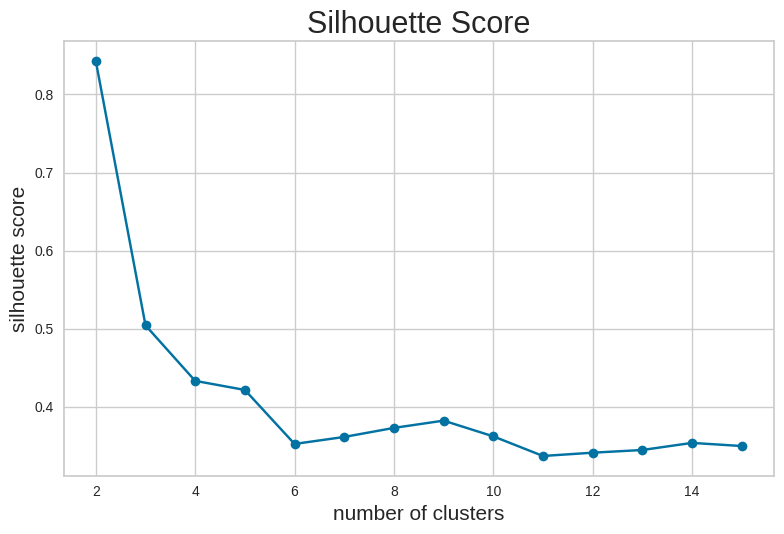

In [56]:
silhouette(RFM_df2, range_clusters)

In the unfiltered case, the silhouette score would suggest k = 2.

**Filtered case**

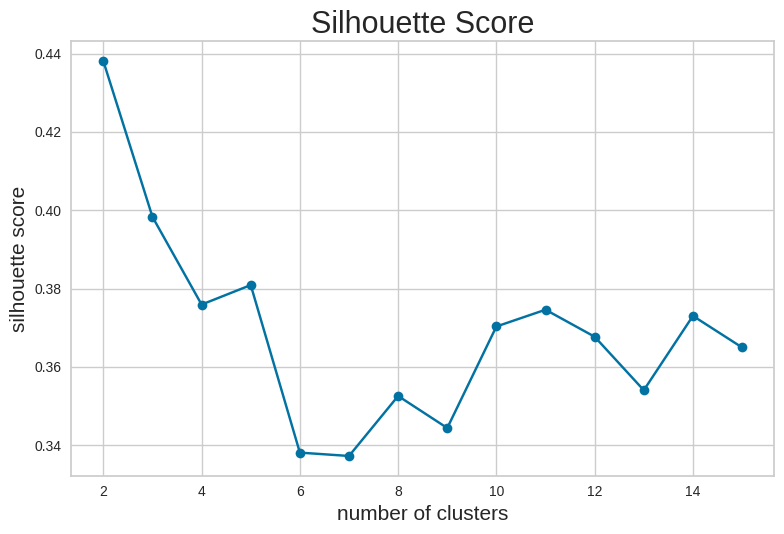

In [57]:
silhouette(RFM_df2_filtered, range_clusters)

One can notice that the scores in the unfiltered case are much higher that in the filtered one. Also that the 'best' value of k in the filtered case is 2.

By taking into account the previous results, I will explore the cases with k = 2 to 5, both in the filtered and unfiltered scenarios.

## 4.2 Tuning the KMeans Model and Results

### 4.2.1 k = 2 Case

**Unfiltered case**

In order to decide what is the 'best' value of k, I will agglomerate clusters with k between 2 and 4 (or 5) and then have a look at the average values of the variables in them and also at their spatial distribution.

I will start with the k = 2 case.

In [58]:
def plot_clusters(k, LABELS):

    # Initiating KMeans. n_clusters = k
    km = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Fit model and predict clusters
    yhat = km.fit_predict(RFM_df2[LABELS])
    RFM_df2[f"{k}_clusters_2D"] = yhat

    # Adding the Clusters feature to the dataframe before encoding and scaling
    RFM_df[f"{k}_clusters_2D"] = yhat

    # Initiating PCA to reduce dimentions to 2
    pca = PCA(n_components=2, random_state=42)

    pca.fit(RFM_df2[LABELS]) 
    data_sc_2D = pd.DataFrame(pca.transform(RFM_df2[LABELS]), columns=(["col1","col2"]))
    data_sc_2D["clusters_2D"] = yhat

    cluster_count = data_sc_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count', ascending=False)

    print(cluster_count)

    ### Figures ###
    bigfig = plt.figure(figsize=(12,6))

    (top, bottom) = bigfig.subfigures(2,1)

    ### Top figure ###
    top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

    k_cluster_data = pd.DataFrame(km.cluster_centers_, columns=LABELS)

    ax = plt.figure(figsize=(12,6))
    
    ax = sns.heatmap(data=k_cluster_data, cmap='RdBu', annot=True)
    ax.set_title('Cluster Centers', fontsize=15)

    plt.suptitle(f'{k} Clusters (Unfiltered) Case', size=30)

    plt.tight_layout()

    ### Bottom figure ###
    bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

    ax1 = sns.barplot(x='clusters_2D', y='count', data=cluster_count, palette='Spectral', ax=ax1)
    ax1.set_xlabel("cluster number", fontsize=15)
    ax1.set_ylabel('count', fontsize=15)
    ax1.set_title(f"Numerical Distribution of the Clusters", fontsize=15)

    ax2 = sns.scatterplot(x="col1", y="col2", data=data_sc_2D, hue="clusters_2D", palette='Spectral', ax=ax2)
    ax2.set_title("2D Representation of the Clusters with PCA", fontsize=15)
    legend_handles,_ = ax2.get_legend_handles_labels()

    plt.tight_layout()

In [59]:
RFM_df2.describe()

,RECENCY,FREQUENCY,MONETARY_VALUE
count,9.200000e+01,9.200000e+01,9.200000e+01
mean,1.399846e-16,2.896234e-17,-2.003229e-16
std,1.005479e+00,1.005479e+00,1.005479e+00
min,-1.740981e+00,-8.033413e-01,-9.107945e-01
25%,-7.557822e-01,-4.595859e-01,-3.547696e-01
50%,2.055953e-01,-1.158306e-01,-2.053434e-01
75%,7.216740e-01,-1.158306e-01,1.050572e-01
max,2.577508e+00,7.790542e+00,7.321687e+00


   clusters_2D  count
0            0     90
1            1      2


<Figure size 1200x600 with 0 Axes>

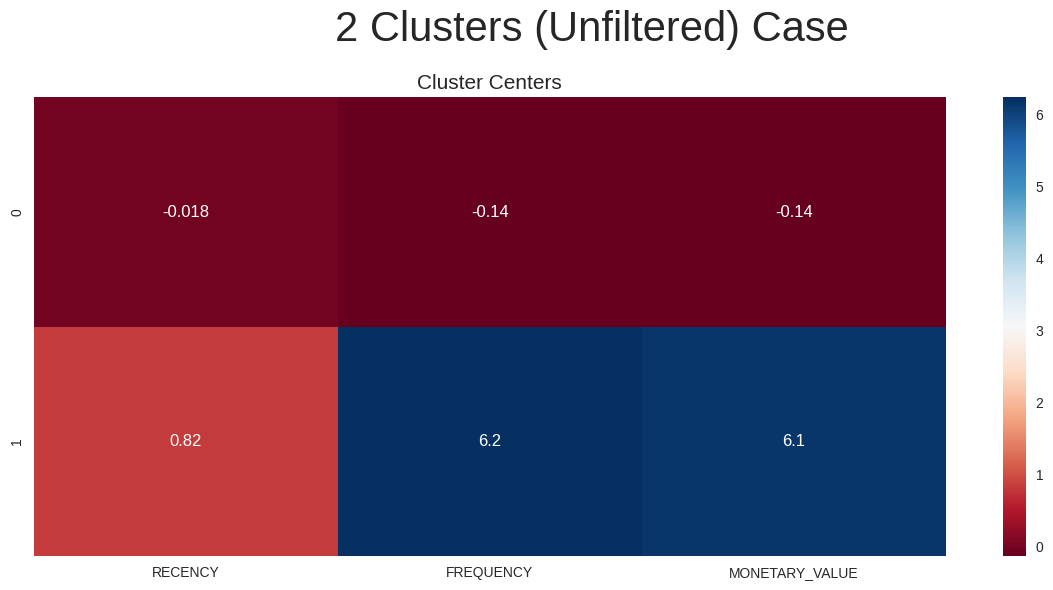

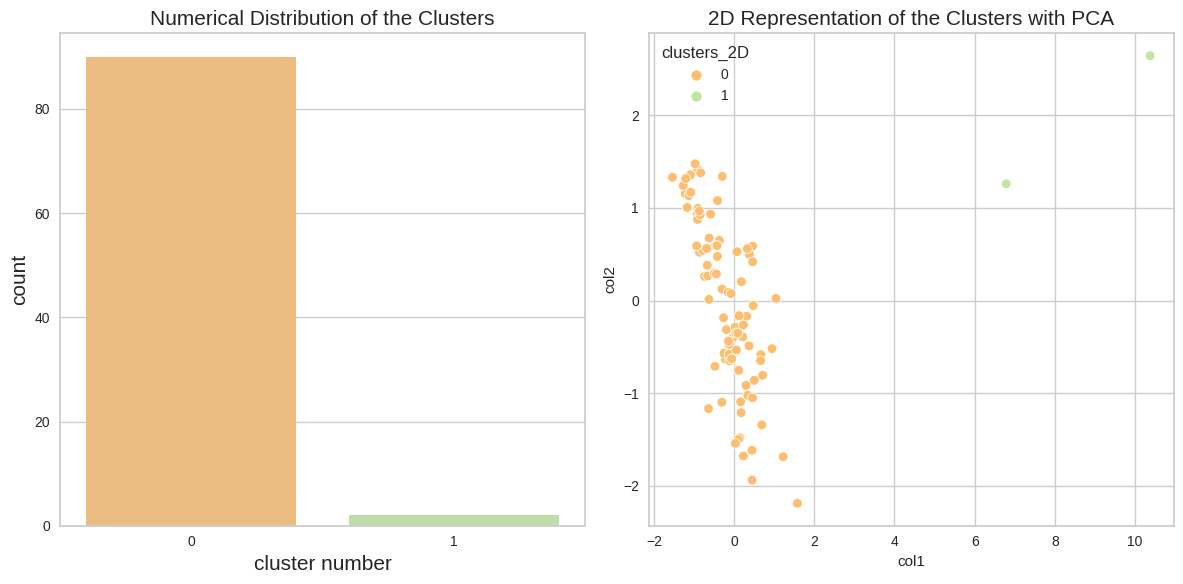

In [60]:
LABELS2 = ['RECENCY', 'FREQUENCY', 'MONETARY_VALUE']

plot_clusters(2, LABELS2)

In the k = 2 (unfiltered) case, I have a cluster with average values of 'RECENCY', 'FREQUENCY' and 'MONETARY_VALUE' and one with very high values of these features, especially those of 'FREQUENCY' and 'MONETARY_VALUE'. This is the cluster of outliers.
<br>One can also notice that the populations of the two clusters are very different and that one of the two clusters is highly underpopulated.

It feels like clustering in this k = 2 case is not so useful, except that this is a way to display the two outliers.

I want to visualize the clusters in the 2D space by means of t-SNE, that is a method to reduce the dimensions alternative to PCA.

Text(0.5, 1.0, '2D Representation of the Clusters with t-SNE')

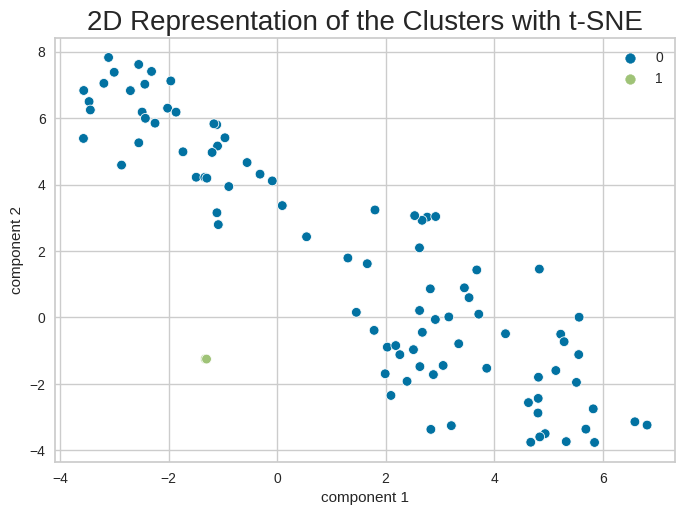

In [61]:
km = KMeans(n_clusters=2, n_init=10, random_state=42)

km.fit(RFM_df2)

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(RFM_df2)

df_tsne = pd.DataFrame(data_tsne,
                       columns=['component 1', 'component 2'])

sns.scatterplot(x='component 1',
                y='component 2',
                data=df_tsne,
                hue=km.labels_)
plt.title("2D Representation of the Clusters with t-SNE", fontsize=20)

In this representation of the data, the green point is clearly an anomaly or outlier.

**Filtered case**

In [62]:
def plot_filtered_clusters(k, LABELS):

    # Initiating KMeans. n_clusters = k
    km = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Fit model and predict clusters
    yhat = km.fit_predict(RFM_df2_filtered[LABELS])
    RFM_df2_filtered[f"{k}_clusters_2D"] = yhat

    # Adding the Clusters feature to the dataframe before encoding and scaling
    RFM_df_filtered[f"{k}_clusters_2D"] = yhat

    # Initiating PCA to reduce dimentions to 2
    pca = PCA(n_components=2, random_state=42)

    pca.fit(RFM_df2_filtered[LABELS]) 
    data_sc_2D_filtered = pd.DataFrame(pca.transform(RFM_df2_filtered[LABELS]), columns=(["col1","col2"]))
    data_sc_2D_filtered["clusters_2D"] = yhat

    cluster_count = data_sc_2D_filtered.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count', ascending=False)

    print(cluster_count)

    ### Figures ###
    bigfig = plt.figure(figsize=(12,6))

    (top, bottom) = bigfig.subfigures(2,1)

    ### Top figure ###
    top.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)

    k_cluster_data = pd.DataFrame(km.cluster_centers_, columns=LABELS)

    ax = plt.figure(figsize=(12,6))
    
    ax = sns.heatmap(data=k_cluster_data, cmap='RdBu', annot=True)
    ax.set_title('Cluster Centers', fontsize=15)

    plt.suptitle(f'{k} Clusters (Filtered) Case', size=30)

    plt.tight_layout()

    ### Bottom figure ###
    bottom.subplots_adjust(left=.1, right=.9, wspace=.4, hspace=.4)
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

    ax1 = sns.barplot(x='clusters_2D', y='count', data=cluster_count, palette='Spectral', ax=ax1)
    ax1.set_xlabel("cluster number", fontsize=15)
    ax1.set_ylabel('count', fontsize=15)
    ax1.set_title(f"Numerical Distribution of the Clusters", fontsize=15)

    ax2 = sns.scatterplot(x="col1", y="col2", data=data_sc_2D_filtered, hue="clusters_2D", palette='Spectral', ax=ax2)
    ax2.set_title("2D Representation of the Clusters with PCA", fontsize=15)
    legend_handles,_ = ax2.get_legend_handles_labels()

    plt.tight_layout()

   clusters_2D  count
1            1     55
0            0     30


<Figure size 1200x600 with 0 Axes>

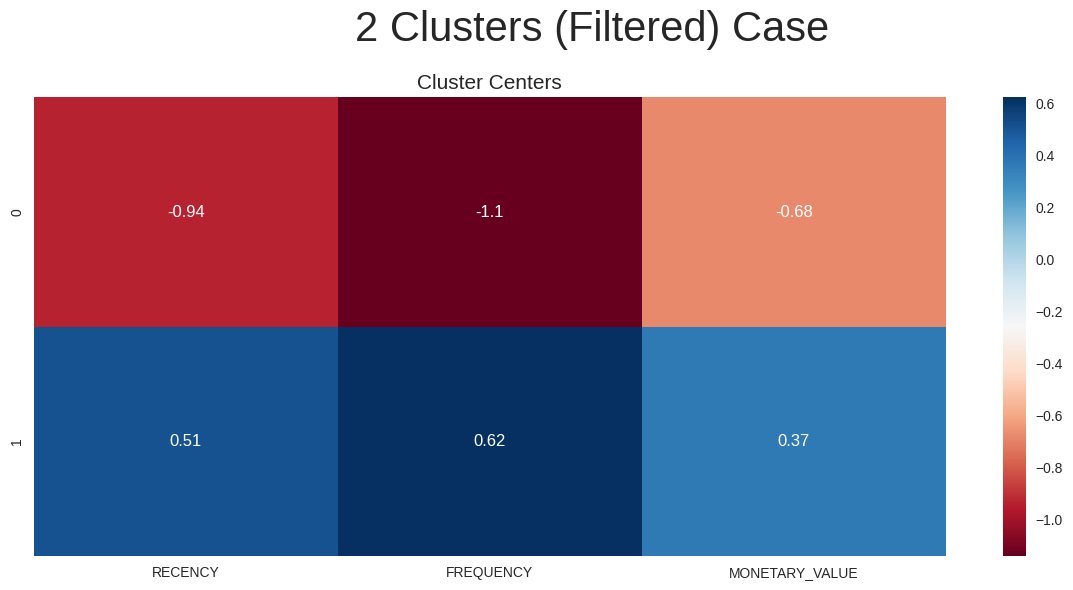

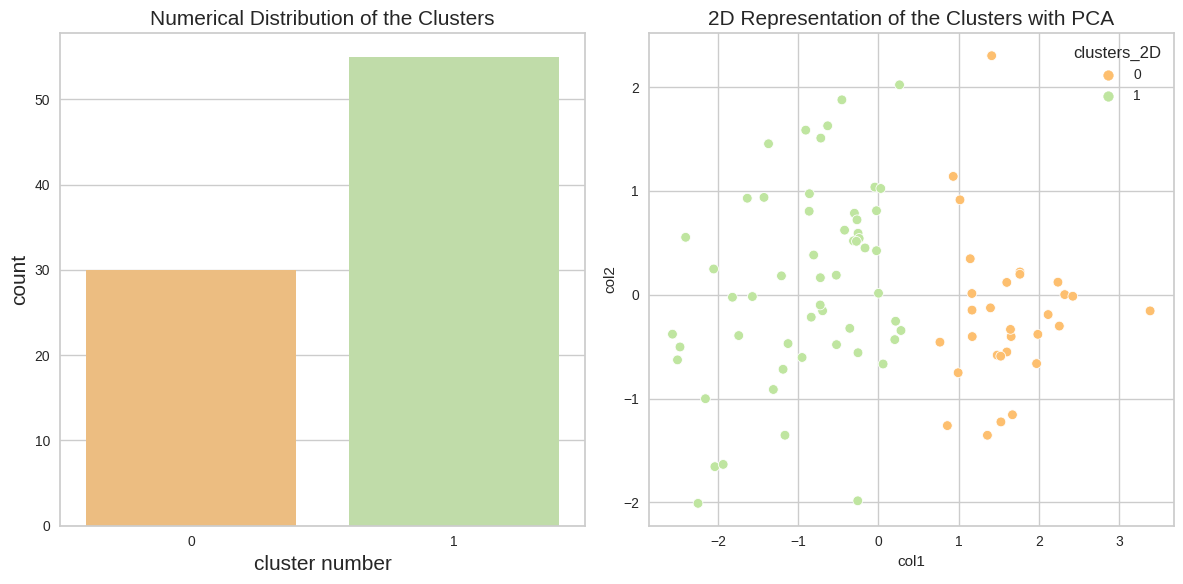

In [63]:
plot_filtered_clusters(2, LABELS2)

Let's try to classify the two clusters.

**Cluster 0:** customers low in RFM indices.

**Cluster 1:** customers relatively high in RFM indices.

Then, I am providing a 2D representation of the clusters by means of t-SNE.

Text(0.5, 1.0, '2D Representation of the Clusters with t-SNE')

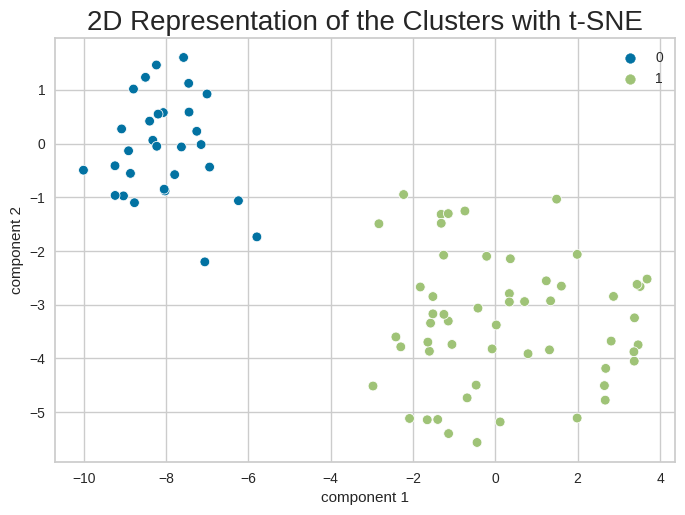

In [64]:
km = KMeans(n_clusters=2, n_init=10, random_state=42)

km.fit(RFM_df2_filtered)

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(RFM_df2_filtered)

df_tsne = pd.DataFrame(data_tsne,
                       columns=['component 1', 'component 2'])

sns.scatterplot(x='component 1',
                y='component 2',
                data=df_tsne,
                hue=km.labels_)
plt.title("2D Representation of the Clusters with t-SNE", fontsize=20)

t-SNE really helps to show that there are two clearly separated clusters.

### 4.2.2 k = 3 Case

**Unfiltered case**

   clusters_2D  count
0            0     46
1            1     44
2            2      2


<Figure size 1200x600 with 0 Axes>

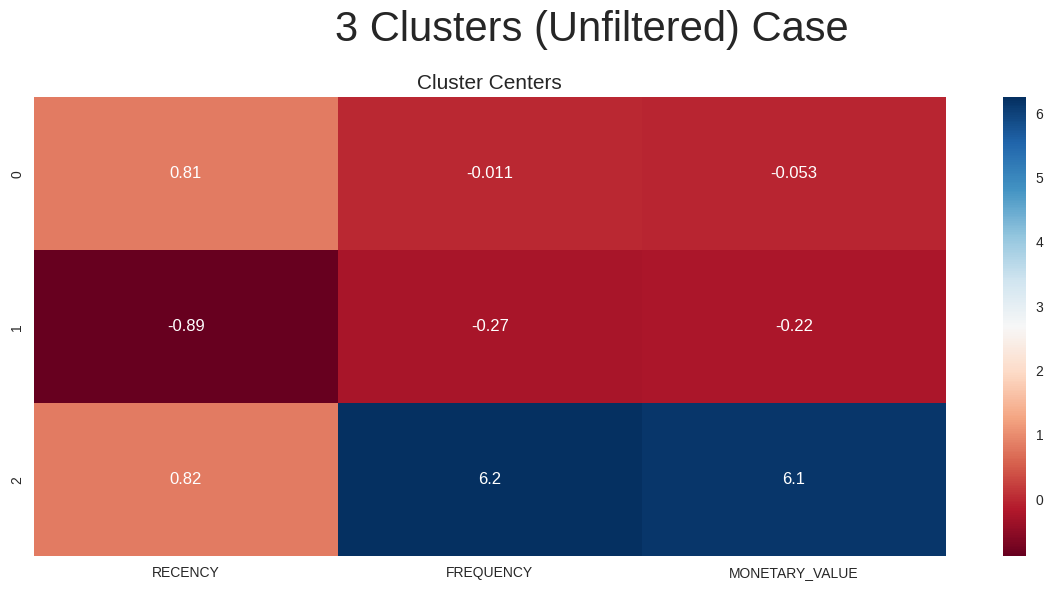

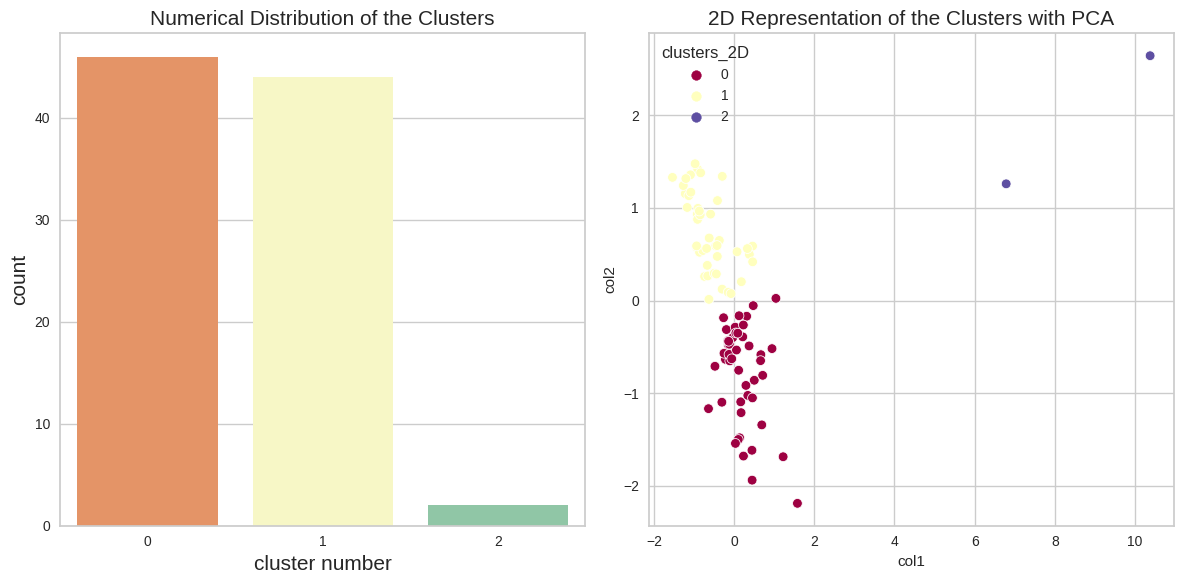

In [65]:
plot_clusters(3, LABELS2)

In this case ('unfiltered' with k = 3), it seems that, because of the very high values of 'FREQUENCY' and 'MONETARY_VALUE' on the cluster of outliers, the values of these variables in the other two clusters are similar and are thus difficult to distinguish. 

This representation of the customers is therefore not so useful.

Text(0.5, 1.0, '2D Representation of the Clusters with t-SNE')

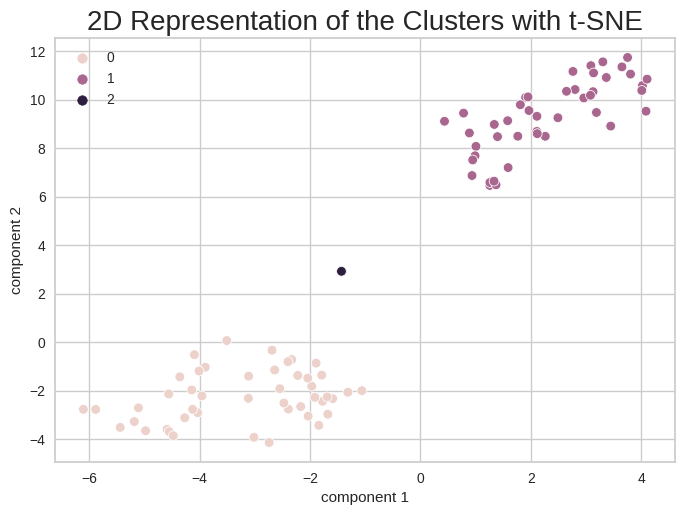

In [66]:
km = KMeans(n_clusters=3, n_init=10, random_state=42)

km.fit(RFM_df2)

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(RFM_df2)

df_tsne = pd.DataFrame(data_tsne,
                       columns=['component 1', 'component 2'])

sns.scatterplot(x='component 1',
                y='component 2',
                data=df_tsne,
                hue=km.labels_)
plt.title("2D Representation of the Clusters with t-SNE", fontsize=20)

**Filtered case**

   clusters_2D  count
0            0     38
1            1     27
2            2     20


<Figure size 1200x600 with 0 Axes>

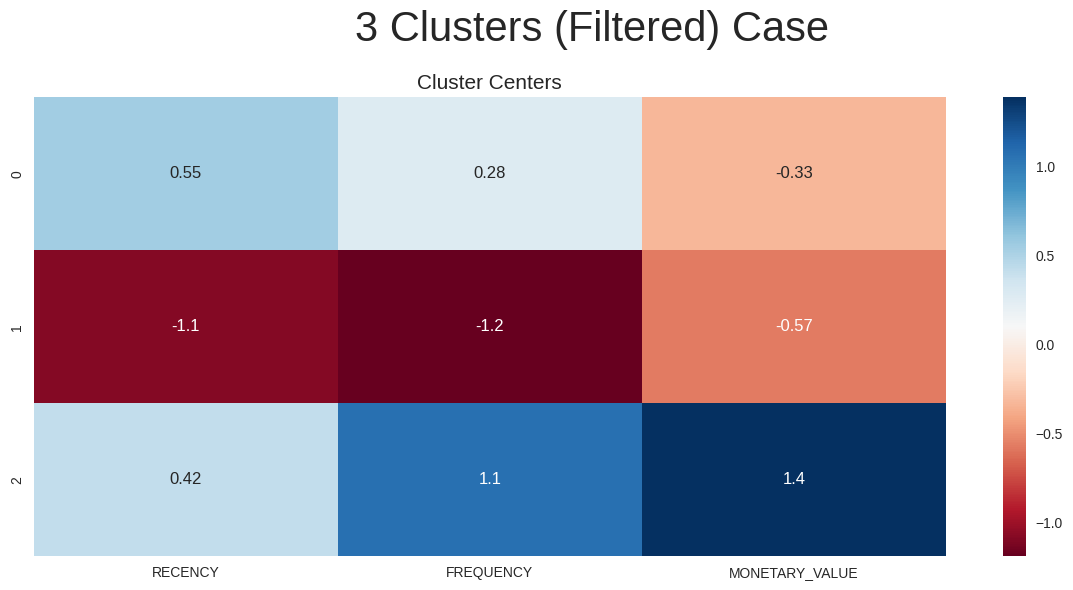

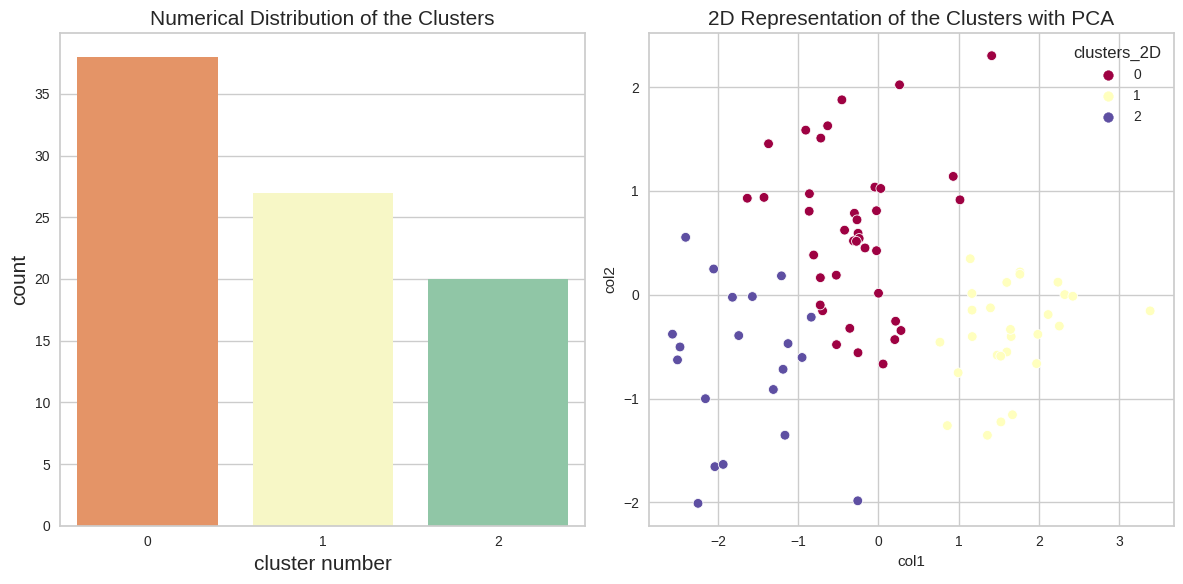

In [67]:
plot_filtered_clusters(3, LABELS2)

In the k = 3 case with filtered data, I have 3 clearly defined clusters.

**Cluster 0:** customers higher than average in both recency and frequency, but lower than average in monetary value (average customers).

**Cluster 1:** customers low in the three RFM variables (bad customers).

**Cluster 2:** customers higher than average in recency and much higher than average in frequency and monetary value (good customers).

Up to now, these are the best results. Let's see if t-SNE can further push towards this choice of k = 3 (and filtered data).

Text(0.5, 1.0, '2D Representation of the Clusters with t-SNE')

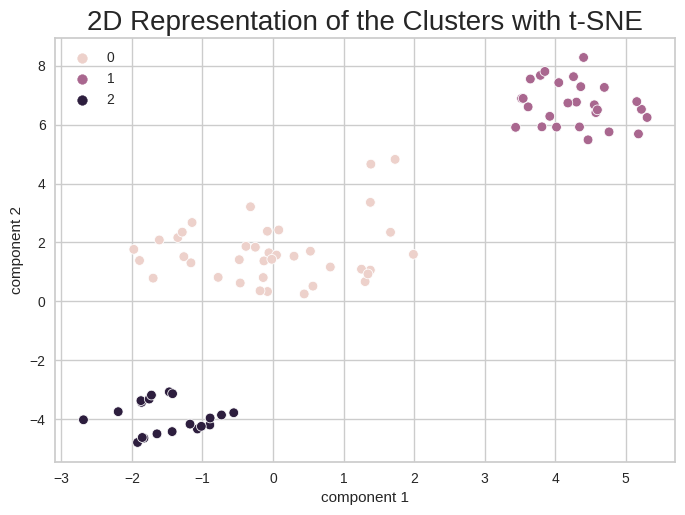

In [68]:
km = KMeans(n_clusters=3, n_init=10, random_state=42)

km.fit(RFM_df2_filtered)

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(RFM_df2_filtered)

df_tsne = pd.DataFrame(data_tsne,
                       columns=['component 1', 'component 2'])

sns.scatterplot(x='component 1',
                y='component 2',
                data=df_tsne,
                hue=km.labels_)
plt.title("2D Representation of the Clusters with t-SNE", fontsize=20)

The 2D cluster representation with t-SNE is really clear: there are three well defined and separated clusters.

### 4.2.3 k = 4 Case

Finally, I will explore the k = 4 case with filtered data.

**Filtered case**

   clusters_2D  count
1            1     27
0            0     25
3            3     21
2            2     12


<Figure size 1200x600 with 0 Axes>

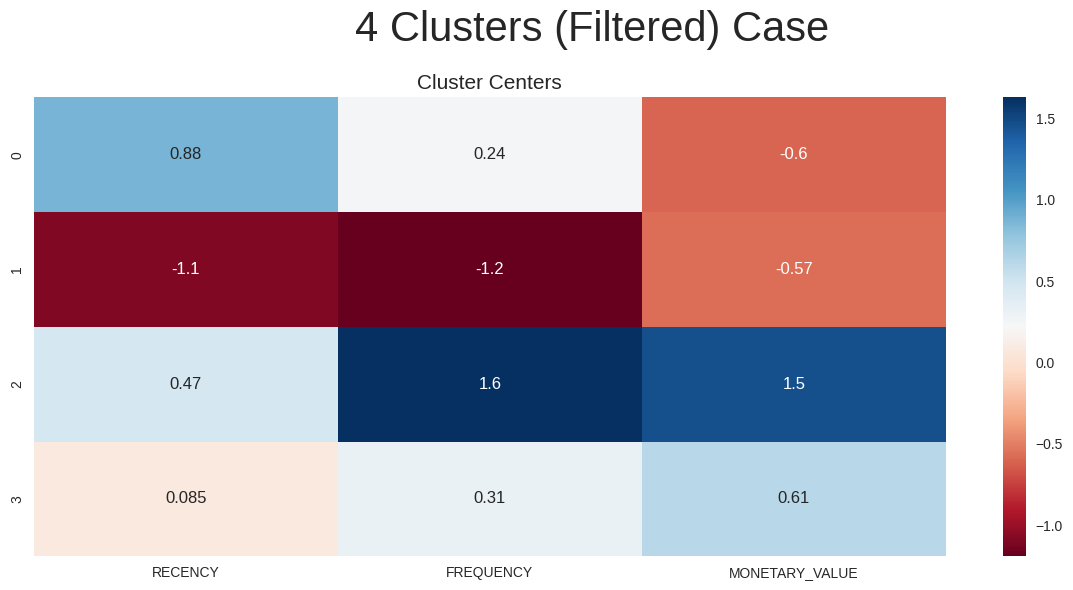

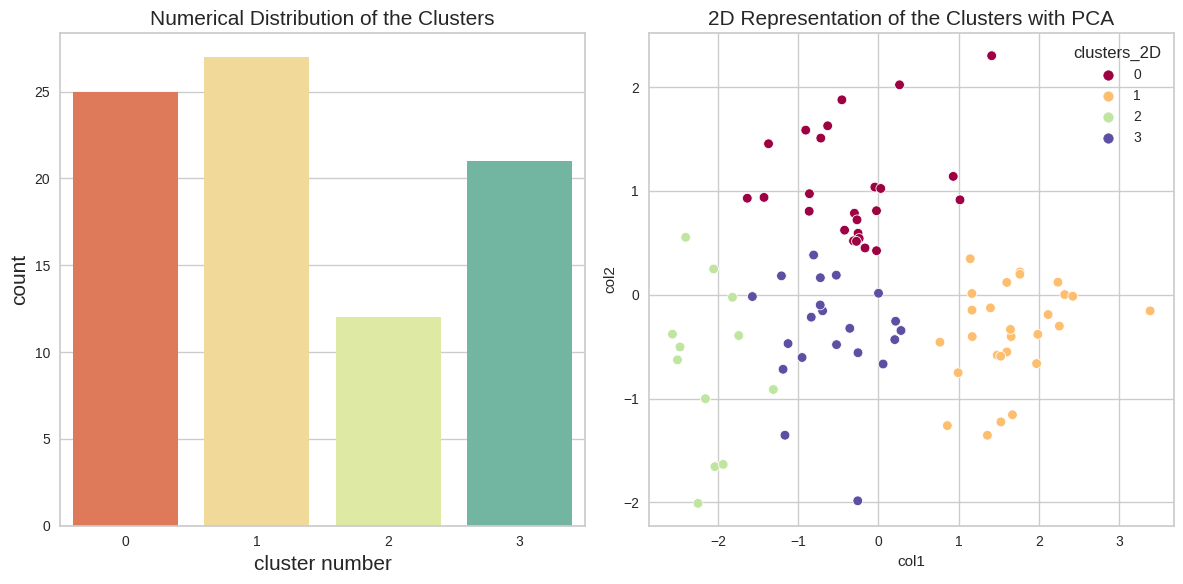

In [69]:
plot_filtered_clusters(4, LABELS2)

Text(0.5, 1.0, '2D Representation of the Clusters with t-SNE')

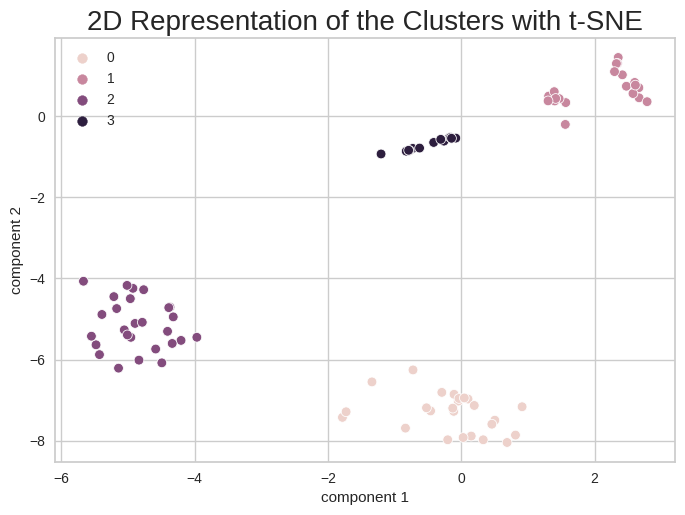

In [70]:
km = KMeans(n_clusters=4, n_init=10, random_state=42)

km.fit(RFM_df2_filtered)

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(RFM_df2_filtered)

df_tsne = pd.DataFrame(data_tsne,
                       columns=['component 1', 'component 2'])

sns.scatterplot(x='component 1',
                y='component 2',
                data=df_tsne,
                hue=km.labels_)
plt.title("2D Representation of the Clusters with t-SNE", fontsize=20)

According to t-SNE, the k = 4 case is as good as k = 3. One could also consider k = 5 or 6 because of the structures in the upper-right corner.

However, I prefer to stick to k = 3 because of the clusters explainability in terms of good, average and bad customers. Moreover, the silhouette and Davies-Bouldin scores are higher for the k = 3 description of the data.

# 5. Final Insights
<a id="5"></a>

## 5.1 Sales by Country

The scale model company sells mainly in the USA and Europe, but also in Australia and Singapore. Even though the USA is the main market, the mean size of the sales by company there is smaller than in other countries. Thus, it would be good to increase the average sales by company in the USA.

## 5.2 Sales by Year and Quarter

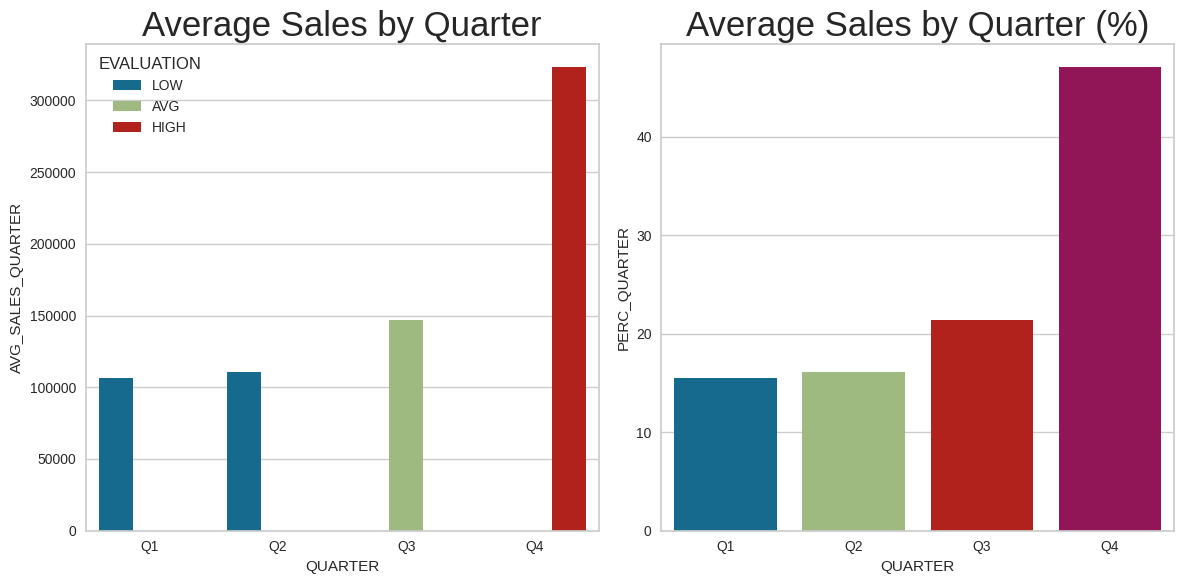

In [71]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=sales_season, x='QUARTER', y='AVG_SALES_QUARTER', hue='EVALUATION', ax=ax1)
ax1.set_title('Average Sales by Quarter', size=25)

ax2 = sns.barplot(data=sales_season, x='QUARTER', y='PERC_QUARTER', ax=ax2)
ax2.set_title('Average Sales by Quarter (%)', size=25)

plt.tight_layout()

Even though there is a positive trend in sales in the 2003-2005 period, around half of them are still made in the fourth quarter. Even though this is expected, because that is the quarter of Christmas, it would be important to try to increase them also in the other quarters.

## 5.3 Cancelled Orders

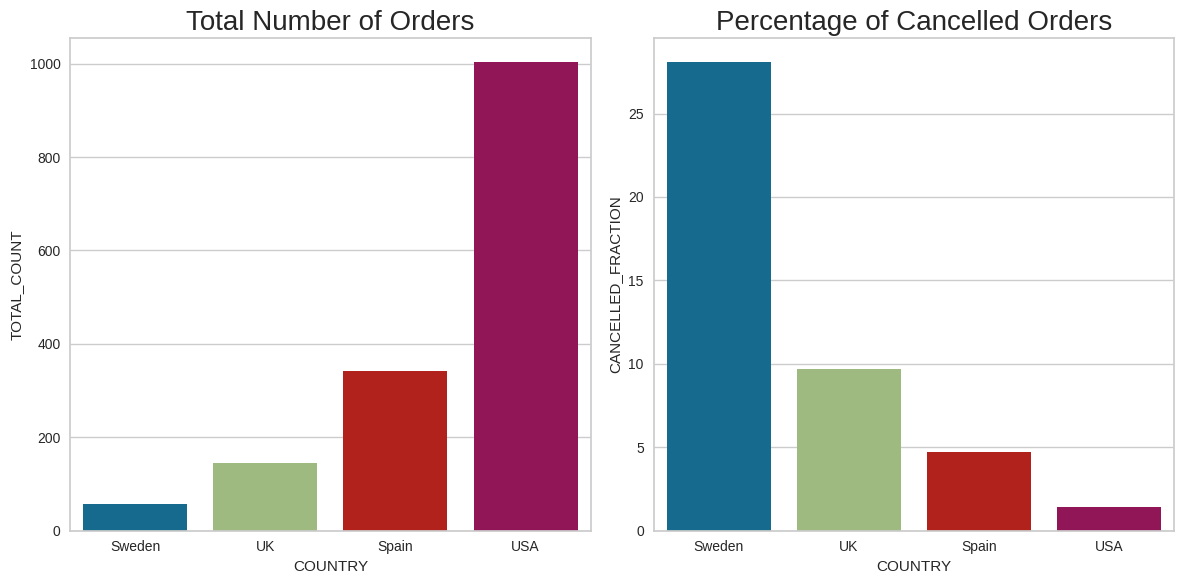

In [72]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1 = sns.barplot(data=cancelled_count, x='COUNTRY', y='TOTAL_COUNT',ax=ax1)
ax1.set_title('Total Number of Orders', size=20)

ax2 = sns.barplot(data=cancelled_count, x='COUNTRY', y='CANCELLED_FRACTION',ax=ax2)
ax2.set_title('Percentage of Cancelled Orders', size=20)

plt.tight_layout()

A relatively small fraction of the orders is cancelled. While this is to be expected, in some countries (like Sweden and the UK) this fraction is much larger than average. Therefore, I think that it would be important to find the reasons for these cancelled orders and reduce their number, especially in the aforementioned countries.

### 4. Customer Types

   clusters_2D  count
0            0     38
1            1     27
2            2     20


<Figure size 1200x600 with 0 Axes>

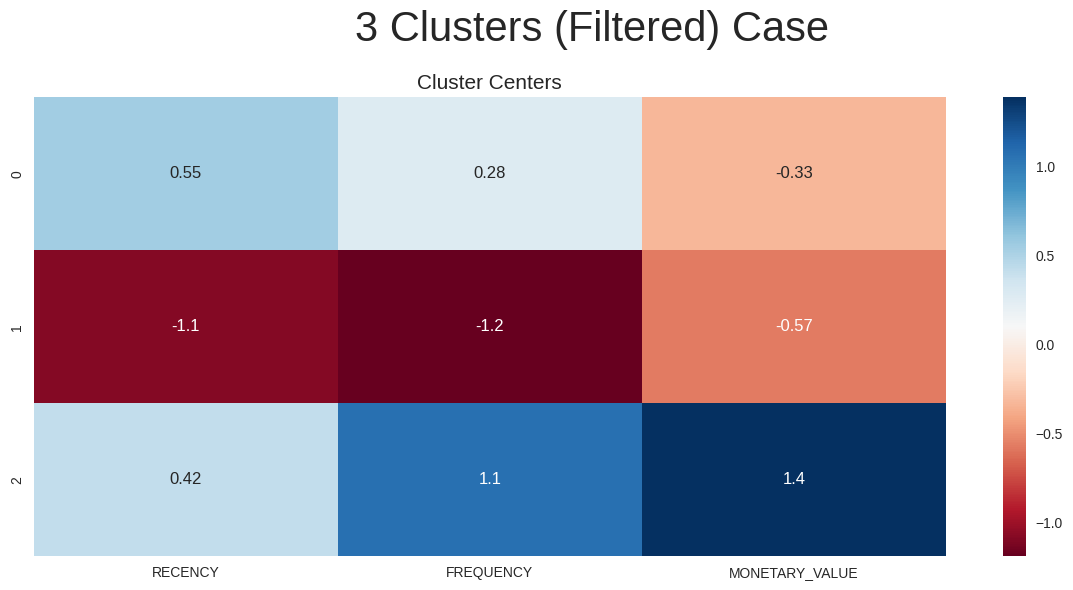

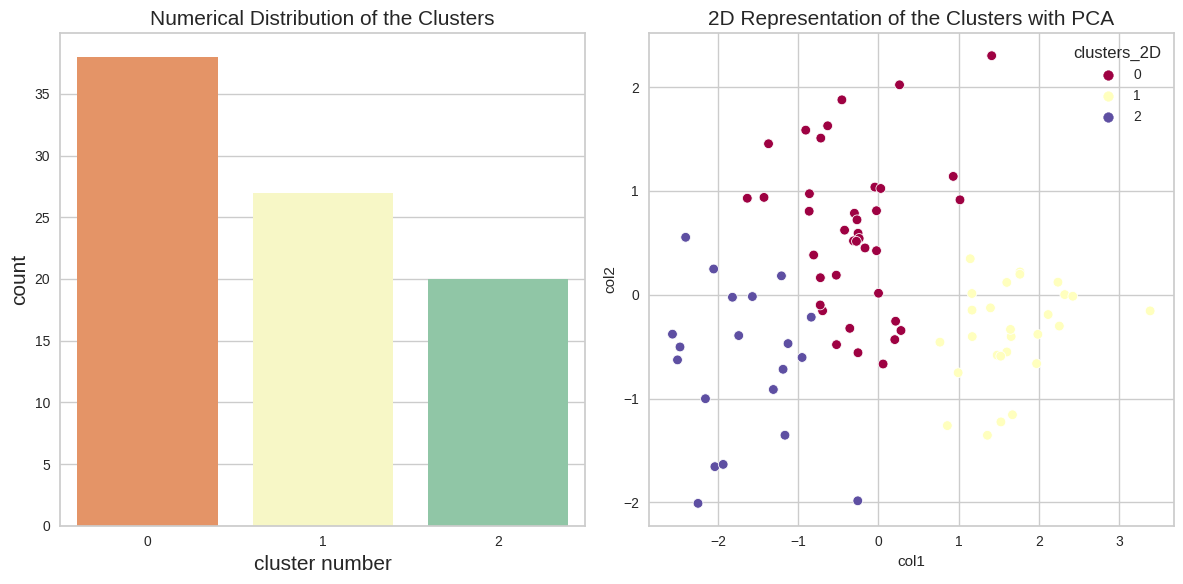

In [73]:
plot_filtered_clusters(3, LABELS2)

By means of a cluster analysis I found out that there are three main categories of customers. They are:

**Cluster 0:** customers higher than average in both recency and frequency, but lower than average in monetary value (average customers).

**Cluster 1:** customers low in the three RFM variables (bad customers).

**Cluster 2:** customers higher than average in recency and much higher than average in frequency and monetary value (good customers).

Given that the 'good' customers are the minority, it would be important to convert some of the 'bad' customers into 'average' ones, and also a part of the 'average' customers into 'good' ones. Also to expand the total number of customers and try to find new ones belonging to the third category (that of Cluster 2).

# References

1. Jacopo Ferretti, [*Avocado Market in the USA (Price & Sales Analysis)*](https://www.kaggle.com/code/jacopoferretti/avocado-market-in-the-usa-price-sales-analysis), notebook on Kaggle.
2. Jacopo Ferretti, [*Favorita Stores Grocery Sales (Time Series)*](https://www.kaggle.com/code/jacopoferretti/favorita-stores-grocery-sales-time-series), notebook on Kaggle.
3. Matthew Connor, [*Customer_Segmentation_Cohort&RFM_Analysis_K-Means*](https://www.kaggle.com/code/azizozmen/customer-segmentation-cohort-rfm-analysis-k-means), notebook on Kaggle.
4. Jacopo Ferretti, [*Superstore: Sales Analysis & Customer Segmentation*](https://www.kaggle.com/code/jacopoferretti/superstore-sales-analysis-customer-segmentation), notebook on Kaggle.
5. Jacopo Ferretti, [*Segmentation Strategies for Mall Customers*](https://www.kaggle.com/code/jacopoferretti/segmentation-strategies-for-mall-customers), notebook on Kaggle.